In [21]:
import pandas as pd

# Load the dataset
data = pd.read_csv('../../data/external/WineQT.csv')

# Describe the dataset
description = data.describe()
print(description)

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

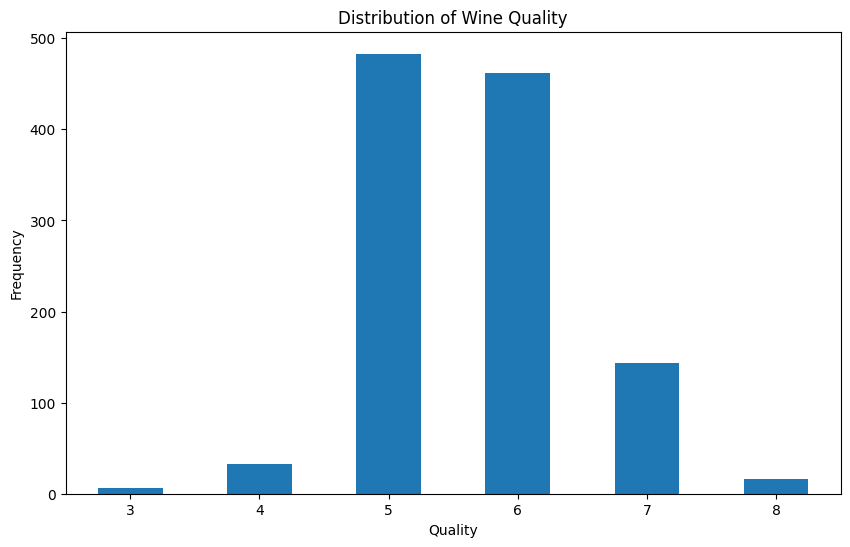

In [22]:
import matplotlib.pyplot as plt

# Plotting the distribution of wine quality
plt.figure(figsize=(10, 6))
data['quality'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Separate features and target variable
X = data.drop('quality', axis=1).values
y = data['quality'].values

# Normalize and standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)
# Split the dataset into training and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

[[-0.52157961  0.93933222 -1.36502663 ... -0.57365783 -0.96338181
  -1.73561799]
 [-0.29259344  1.94181282 -1.36502663 ...  0.1308811  -0.59360107
  -1.73346186]
 [-0.29259344  1.27349242 -1.16156762 ... -0.04525363 -0.59360107
  -1.73130573]
 ...
 [-1.20853813  0.38239855 -0.9581086  ... -0.45623467  0.05351522
   1.70125196]
 [-1.38027776  0.10393172 -0.8563791  ...  0.60057372  0.70063152
   1.70340809]
 [-1.38027776  0.6330187  -0.75464959 ...  0.30701583 -0.22382033
   1.70772035]]


In [28]:
import numpy as np

class MLP:
    def __init__(self, 
                 hidden_layers, 
                 learning_rate=0.01,
                 activation='sigmoid',
                 optimizer='sgd',
                 batch_size=32,
                 epochs=100,
                 early_stopping_patience=10):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience
        self.weights = []
        self.biases = []
        self.losses = [] 

    def _initialize_parameters(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i])))

    def _activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -709, 709)))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Invalid activation function")

    def _activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - np.power(x, 2)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        else:
            raise ValueError("Invalid activation function")

    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self._activation_function(z)
            activations.append(a)
        return activations

    def _backpropagation(self, X, y):
        m = X.shape[0]
        activations = self._forward_propagation(X)
        
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        delta = activations[-1] - y
        for l in range(len(self.weights) - 1, -1, -1):
            dW[l] = np.dot(activations[l].T, delta) / m
            db[l] = np.sum(delta, axis=0, keepdims=True) / m
            if l > 0:
                delta = np.dot(delta, self.weights[l].T) * self._activation_derivative(activations[l])
        
        return dW, db

    def _update_parameters(self, dW, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Adjust output values to be between 0 and 5 (for one-hot encoding)
        y_adjusted = y - 3
        
        # Initialize parameters
        n_classes = 6
        self._initialize_parameters(n_features, n_classes)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y_adjusted[indices]
                for i in range(n_samples):
                    dW, db = self._backpropagation(X_shuffled[i:i+1], np.eye(n_classes)[y_shuffled[i:i+1]])
                    self._update_parameters(dW, db)

            elif self.optimizer == 'batch':
                dW, db = self._backpropagation(X, np.eye(n_classes)[y_adjusted])
                self._update_parameters(dW, db)

            elif self.optimizer == 'mini_batch':
                for i in range(0, n_samples, self.batch_size):
                    batch_X = X[i:i+self.batch_size]
                    batch_y = y_adjusted[i:i+self.batch_size]
                    dW, db = self._backpropagation(batch_X, np.eye(n_classes)[batch_y])
                    self._update_parameters(dW, db)

            # Compute and store the loss for this epoch
            loss = self._compute_cost(X, np.eye(n_classes)[y_adjusted])
            self.losses.append(loss)  # Store the loss
            
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    def predict(self, X):
        activations = self._forward_propagation(X)
        predicted_indices = np.argmax(activations[-1], axis=1)
        
        # Adjust back to original quality scores (3-8)
        return predicted_indices + 3

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def _compute_cost(self, X, y):
        activations = self._forward_propagation(X)
        m = X.shape[0]
        epsilon = 1e-15
        cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m
        return cost

    def gradient_check(self, X, y, epsilon=1e-7):
        y_adjusted = y - 3
        y_encoded = np.eye(6)[y_adjusted]
        
        dW, db = self._backpropagation(X, y_encoded)
        
        params = self.weights + self.biases
        grads = dW + db
        
        num_grads = []
        for param in params:
            num_grad = np.zeros_like(param)
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                idx = it.multi_index
                old_value = param[idx]
                
                param[idx] = old_value + epsilon
                cost_plus = self._compute_cost(X, y_encoded)
                
                param[idx] = old_value - epsilon
                cost_minus = self._compute_cost(X, y_encoded)
                
                num_grad[idx] = (cost_plus - cost_minus) / (2 * epsilon)
                
                param[idx] = old_value
                it.iternext()
            
            num_grads.append(num_grad)
        
        total_error = 0
        for grad, num_grad in zip(grads, num_grads):
            numerator = np.linalg.norm(grad - num_grad)
            denominator = np.linalg.norm(grad) + np.linalg.norm(num_grad)
            total_error += numerator / (denominator + 1e-7)
        
        average_error = total_error / len(params)
        print(f"Average relative error: {average_error}")
        
        return average_error < 1e-7


if __name__ == "__main__":
    
    # Create an instance of the MLP class with specified parameters.
    mlp=MLP(hidden_layers=[9],
            learning_rate=0.01,
            activation='sigmoid',
            optimizer='sgd',batch_size=32,
            epochs=1000)

    # Fit the model on training data.
    mlp.fit(X_train,y_train)

    # Make predictions on the test set.
    predictions=mlp.predict(X_val)

   # Calculate accuracy.
    accuracy_score=mlp.accuracy(y_val,predictions)
    print(f"Accuracy: {accuracy_score * 100:.2f}%")

    # Perform gradient checking on a sample of test data.
    is_gradient_correct=mlp.gradient_check(X_val,y_val)
    print(f"Gradient check passed: {is_gradient_correct}")

Early stopping at epoch 524
Accuracy: 64.04%
Average relative error: 2.9110100995612392e-08
Gradient check passed: True


In [20]:
import numpy as np
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

class MLP_hyperparam:
    def __init__(self, config):
        self.hidden_layers = config.hidden_layers
        self.learning_rate = config.learning_rate
        self.activation = config.activation
        self.optimizer = config.optimizer
        self.batch_size = config.batch_size
        self.epochs = config.epochs
        self.early_stopping_patience = config.early_stopping_patience
        self.weights = []
        self.biases = []

    def _initialize_parameters(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i])))

    def _activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Invalid activation function")

    def _activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - np.power(x, 2)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        else:
            raise ValueError("Invalid activation function")

    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self._activation_function(z)
            activations.append(a)
        return activations

    def _backpropagation(self, X, y):
        m = X.shape[0]
        activations = self._forward_propagation(X)
        
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        delta = activations[-1] - y
        for l in range(len(self.weights) - 1, -1, -1):
            dW[l] = np.dot(activations[l].T, delta) / m
            db[l] = np.sum(delta, axis=0, keepdims=True) / m
            if l > 0:
                delta = np.dot(delta, self.weights[l].T) * self._activation_derivative(activations[l])
        
        return dW, db

    def _update_parameters(self, dW, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X_train, y_train, X_val, y_val):
        
        n_samples, n_features = X_train.shape
        
        # Adjust output values to be between 0 and 5 (for one-hot encoding)
        y_train_adjusted = y_train - 3  # Shift labels from [3-8] to [0-5]
        y_val_adjusted = y_val - 3
        
        # Initialize parameters
        n_classes = 6  # Since we have classes from 0 to 5 after adjustment
        self._initialize_parameters(n_features, n_classes)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                indices = np.random.permutation(n_samples)
                X_shuffled = X_train[indices]
                y_shuffled = y_train_adjusted[indices]
                for i in range(n_samples):
                    dW, db = self._backpropagation(X_shuffled[i:i+1], np.eye(n_classes)[y_shuffled[i:i+1]])
                    self._update_parameters(dW, db)
            elif self.optimizer == 'batch':
                dW, db = self._backpropagation(X_train, np.eye(n_classes)[y_train_adjusted])
                self._update_parameters(dW, db)
            elif self.optimizer == 'mini_batch':
                for i in range(0, n_samples, self.batch_size):
                    batch_X = X_train[i:i+self.batch_size]
                    batch_y = y_train_adjusted[i:i+self.batch_size]
                    dW, db = self._backpropagation(batch_X, np.eye(n_classes)[batch_y])
                    self._update_parameters(dW, db)

            train_loss = self._compute_cost(X_train, np.eye(n_classes)[y_train_adjusted])
            val_loss = self._compute_cost(X_val, np.eye(n_classes)[y_val_adjusted])
            
            train_pred = self.predict(X_train)
            val_pred = self.predict(X_val)
            train_accuracy = self.accuracy(y_train, train_pred)
            val_accuracy = self.accuracy(y_val, val_pred)
            
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy
            })
            
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        # Compute final metrics
        final_pred = self.predict(X_val)
        final_metrics = {
            "val_accuracy": accuracy_score(y_val, final_pred),
            "val_f1": f1_score(y_val, final_pred, average='weighted'),
            "val_precision": precision_score(y_val, final_pred, average='weighted'),
            "val_recall": recall_score(y_val, final_pred, average='weighted')
        }
        wandb.log(final_metrics)

    def predict(self, X):
        activations = self._forward_propagation(X)
        predicted_indices = np.argmax(activations[-1], axis=1)
        
        # Adjust back to original quality scores (3-8)
        return predicted_indices + 3

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def _compute_cost(self, X, y):
        activations = self._forward_propagation(X)
        m = X.shape[0]
        epsilon = 1e-15
        cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m
        return cost

    def gradient_check(self, X, y, epsilon=1e-7):
        y_adjusted = y - 3
        y_encoded = np.eye(6)[y_adjusted]
        
        dW, db = self._backpropagation(X, y_encoded)
        
        params = self.weights + self.biases
        grads = dW + db
        
        num_grads = []
        for param in params:
            num_grad = np.zeros_like(param)
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                idx = it.multi_index
                old_value = param[idx]
                
                param[idx] = old_value + epsilon
                cost_plus = self._compute_cost(X, y_encoded)
                
                param[idx] = old_value - epsilon
                cost_minus = self._compute_cost(X, y_encoded)
                
                num_grad[idx] = (cost_plus - cost_minus) / (2 * epsilon)
                
                param[idx] = old_value
                it.iternext()
            
            num_grads.append(num_grad)
        
        total_error = 0
        for grad, num_grad in zip(grads, num_grads):
            numerator = np.linalg.norm(grad - num_grad)
            denominator = np.linalg.norm(grad) + np.linalg.norm(num_grad)
            total_error += numerator / (denominator + 1e-7)
        
        average_error = total_error / len(params)
        print(f"Average relative error: {average_error}")
        
        return average_error < 1e-7
    
def train():
    # Load your data here
    # X, y = load_data()  # Implement this function to load your dataset
    
    # For demonstration, let's create some dummy data
    # X = np.random.randn(1000, 10)
    # y = np.random.randint(3, 9, size=1000)

    config_defaults = {
        'hidden_layers': [64],
        'learning_rate': 0.01,
        'activation': 'sigmoid',
        'optimizer': 'sgd',
        'batch_size': 32,
        'epochs': 100,
        'early_stopping_patience': 10
    }

    wandb.init(config=config_defaults)
    config = wandb.config

    model = MLP_hyperparam(config)
    model.fit(X_train, y_train, X_val, y_val)

sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        'hidden_layers': {'values': [[9], [10, 8], [64, 32]]},
        'learning_rate': {'min': 0.0001, 'max': 0.1},
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},
        'optimizer': {'values': ['sgd', 'batch', 'mini_batch']},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [50, 100, 150]},
        'early_stopping_patience': {'values': [5, 10, 15]}
    }
}

sweep_id = wandb.sweep(sweep_configuration, project="MLP_Hyperparameter_Tuning")
wandb.agent(sweep_id, train, count=20)  # Run 20 experiments

# After the sweep is complete, you can get the best run:
api = wandb.Api()
sweep = api.sweep(f"your_username/MLP_Hyperparameter_Tuning/{sweep_id}")
best_run = sweep.best_run()
print(f"Best run id: {best_run.id}")
print(f"Best run config: {best_run.config}")
print(f"Best run metrics: {best_run.summary}")

Create sweep with ID: dty5miyw
Sweep URL: https://wandb.ai/dusaneyash09-iiit-hyderabad/MLP_Hyperparameter_Tuning/sweeps/dty5miyw


wandb: Agent Starting Run: htj2ilda with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	early_stopping_patience: 5
wandb: 	epochs: 150
wandb: 	hidden_layers: [10, 8]
wandb: 	learning_rate: 0.08087946999079179
wandb: 	optimizer: sgd


C:\Users\yashd\AppData\Local\Temp\ipykernel_4724\1362981141.py:155: RuntimeWarning: invalid value encountered in log
  cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m


Early stopping at epoch 4


c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch,▁▃▅▆█
train_accuracy,▁▇█▄█
val_accuracy,▁▅█▆▇▇
val_f1,▁
val_precision,▁
val_recall,▁
epoch,4
train_accuracy,0.5919
train_loss,nan
val_accuracy,0.61404
val_f1,0.57494


wandb: Ctrl + C detected. Stopping sweep.


CommError: Could not find sweep <Sweep your_username/MLP_Hyperparameter_Tuning/dty5miyw (Unknown State)>

In [6]:
# import numpy as np
# import wandb
# from sklearn.metrics import precision_score, recall_score, f1_score

# class MLP:
#     def __init__(self, 
#                  hidden_layers, 
#                  learning_rate=0.01,
#                  activation='sigmoid',
#                  optimizer='sgd',
#                  batch_size=32,
#                  epochs=100,
#                  early_stopping_patience=10):
#         self.hidden_layers = hidden_layers
#         self.learning_rate = learning_rate
#         self.activation = activation
#         self.optimizer = optimizer
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.early_stopping_patience = early_stopping_patience
#         self.weights = []
#         self.biases = []

#     def _initialize_parameters(self, input_size, output_size):
#         layer_sizes = [input_size] + self.hidden_layers + [output_size]
#         for i in range(1, len(layer_sizes)):
#             self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) / np.sqrt(layer_sizes[i-1]))
#             self.biases.append(np.zeros((1, layer_sizes[i])))

#     def _activation_function(self, x):
#         if self.activation == 'sigmoid':
#             return 1 / (1 + np.exp(-np.clip(x, -709, 709)))  # Clip to avoid overflow
#         elif self.activation == 'tanh':
#             return np.tanh(x)
#         elif self.activation == 'relu':
#             return np.maximum(0, x)
#         elif self.activation == 'linear':
#             return x
#         else:
#             raise ValueError("Invalid activation function")

#     def _activation_derivative(self, x):
#         if self.activation == 'sigmoid':
#             return x * (1 - x)
#         elif self.activation == 'tanh':
#             return 1 - np.power(x, 2)
#         elif self.activation == 'relu':
#             return np.where(x > 0, 1, 0)
#         elif self.activation == 'linear':
#             return np.ones_like(x)
#         else:
#             raise ValueError("Invalid activation function")

#     def _forward_propagation(self, X):
#         activations = [X]
#         for i in range(len(self.weights)):
#             z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
#             a = self._activation_function(z)
#             activations.append(a)
#         return activations

#     def _backpropagation(self, X, y):
#         m = X.shape[0]
#         activations = self._forward_propagation(X)
        
#         dW = [np.zeros_like(w) for w in self.weights]
#         db = [np.zeros_like(b) for b in self.biases]
        
#         delta = activations[-1] - y
#         for l in range(len(self.weights) - 1, -1, -1):
#             dW[l] = np.dot(activations[l].T, delta) / m
#             db[l] = np.sum(delta, axis=0, keepdims=True) / m
#             if l > 0:
#                 delta = np.dot(delta, self.weights[l].T) * self._activation_derivative(activations[l])
        
#         return dW, db

#     def _update_parameters(self, dW, db):
#         for i in range(len(self.weights)):
#             self.weights[i] -= self.learning_rate * dW[i]
#             self.biases[i] -= self.learning_rate * db[i]

#     def fit(self, X_train, y_train, X_val=None, y_val=None):
        
#         n_samples, n_features = X_train.shape
        
#         # Adjust output values to be between 0 and 5 (for one-hot encoding)
#         y_adjusted_train = y_train - 3
        
#         # Initialize parameters
#         n_classes = 6  
#         self._initialize_parameters(n_features, n_classes)
        
#         best_loss = float('inf')
#         patience_counter = 0
        
#         # Initialize W&B logging
#         wandb.init(project="mlp-hyperparameter-tuning", config={
#             "learning_rate": self.learning_rate,
#             "epochs": self.epochs,
#             "batch_size": self.batch_size,
#             "hidden_layers": str(self.hidden_layers),
#             "activation": self.activation,
#             "optimizer": self.optimizer
#         })
        
#         for epoch in range(self.epochs):
#             # Training phase
#             if self.optimizer == 'sgd':
#                 indices = np.random.permutation(n_samples)
#                 X_shuffled = X_train[indices]
#                 y_encoded_shuffled = y_adjusted_train[indices]
#                 for i in range(n_samples):
#                     dW, db = self._backpropagation(X_shuffled[i:i+1], np.eye(n_classes)[y_encoded_shuffled[i:i+1]])
#                     self._update_parameters(dW, db)

#             elif self.optimizer == 'batch':
#                 dW, db = self._backpropagation(X_train, np.eye(n_classes)[y_adjusted_train])
#                 self._update_parameters(dW, db)

#             elif self.optimizer == 'mini_batch':
#                 for i in range(0, n_samples, self.batch_size):
#                     batch_X = X_train[i:i+self.batch_size]
#                     batch_y = y_adjusted_train[i:i+self.batch_size]
#                     dW, db = self._backpropagation(batch_X, np.eye(n_classes)[batch_y])
#                     self._update_parameters(dW, db)

#             train_loss = self._compute_cost(X_train, np.eye(n_classes)[y_adjusted_train])
            
#             # Log metrics to W&B
#             wandb.log({"epoch": epoch + 1,
#                         "train_loss": train_loss})

#             if X_val is not None and y_val is not None:
#                 val_loss = self._compute_cost(X_val, np.eye(n_classes)[y_val - 3])
#                 val_accuracy = self.accuracy(y_val, self.predict(X_val))
                
#                 # Log validation metrics to W&B
#                 wandb.log({"val_loss": val_loss,
#                             "val_accuracy": val_accuracy})

#                 if val_loss < best_loss:
#                     best_loss = val_loss
#                     patience_counter = 0
#                 else:
#                     patience_counter += 1
#                     if patience_counter >= self.early_stopping_patience:
#                         print(f"Early stopping at epoch {epoch}")
#                         break

#     def predict(self, X):
#         activations = self._forward_propagation(X)
#         predicted_indices = np.argmax(activations[-1], axis=1)
        
#         # Adjust back to original quality scores (3-8)
#         return predicted_indices + 3

#     def accuracy(self, y_true, y_pred):
#         return np.mean(y_true == y_pred)

#     def _compute_cost(self, X, y):
#        activations=self._forward_propagation(X)
#        m=X.shape[0]
#        epsilon=1e-15 # To avoid log(0).
#        cost=-np.sum(y*np.log(activations[-1]+epsilon))/m
      
#        return cost

# # Example usage:
# if __name__ == "__main__":
   
#        # Create an instance of the MLP class with specified parameters.
#     mlp=MLP(hidden_layers=[10],learning_rate=0.01,batch_size=32,
#                 epochs=1000)

#     # Fit the model on training data and validate on test data.
#     mlp.fit(X_train,y_train,X_test,y_test)

#     # Make predictions on the test set.
#     predictions=mlp.predict(X_test)

#     # Calculate accuracy.
#     accuracy_score=mlp.accuracy(y_test,predictions)
#     print(f"Accuracy: {accuracy_score * 100:.2f}%")

#     # Calculate additional metrics.
#     precision = precision_score(y_test, predictions, average='weighted')
#     recall = recall_score(y_test, predictions, average='weighted')
#     f1 = f1_score(y_test, predictions, average='weighted')

#     print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dusaneyash09 (dusaneyash09-iiit-hyderabad). Use `wandb login --relogin` to force relogin


Early stopping at epoch 32
Accuracy: 63.76%
Precision: 0.61, Recall: 0.64, F1 Score: 0.62


c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# import numpy as np
# import wandb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# class MLPClassifier:
#     def __init__(self, 
#                  hidden_layers, 
#                  learning_rate=0.01,
#                  activation='sigmoid',
#                  optimizer='sgd',
#                  batch_size=32,
#                  epochs=100,
#                  early_stopping_patience=10):
#         self.hidden_layers = hidden_layers
#         self.learning_rate = learning_rate
#         self.activation = activation
#         self.optimizer = optimizer
#         self.batch_size = batch_size
#         self.epochs = epochs
#         self.early_stopping_patience = early_stopping_patience
#         self.weights = []
#         self.biases = []
#         self.class_mapping = {}
#         self.inverse_class_mapping = {}

#     def _initialize_parameters(self, input_size, output_size):
#         layer_sizes = [input_size] + self.hidden_layers + [output_size]
#         for i in range(1, len(layer_sizes)):
#             self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) / np.sqrt(layer_sizes[i-1]))
#             self.biases.append(np.zeros((1, layer_sizes[i])))

#     def _activation_function(self, x):
#         activations = {
#             'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
#             'tanh': np.tanh,
#             'relu': lambda x: np.maximum(0, x),
#             'linear': lambda x: x
#         }
#         return activations[self.activation](x)

#     def _activation_derivative(self, x):
#         derivatives = {
#             'sigmoid': lambda x: x * (1 - x),
#             'tanh': lambda x: 1 - np.power(x, 2),
#             'relu': lambda x: np.where(x > 0, 1, 0),
#             'linear': lambda x: np.ones_like(x)
#         }
#         return derivatives[self.activation](x)

#     def _forward_propagation(self, X):
#         activations = [X]
#         for i in range(len(self.weights)):
#             z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
#             a = self._activation_function(z)
#             activations.append(a)
#         return activations

#     def _backpropagation(self, X, y):
#         m = X.shape[0]
#         activations = self._forward_propagation(X)
        
#         dW = [np.zeros_like(w) for w in self.weights]
#         db = [np.zeros_like(b) for b in self.biases]
        
#         delta = activations[-1] - y
#         for l in range(len(self.weights) - 1, -1, -1):
#             dW[l] = np.dot(activations[l].T, delta) / m
#             db[l] = np.sum(delta, axis=0, keepdims=True) / m
#             if l > 0:
#                 delta = np.dot(delta, self.weights[l].T) * self._activation_derivative(activations[l])
        
#         return dW, db

#     def _update_parameters(self, dW, db):
#         for i in range(len(self.weights)):
#             self.weights[i] -= self.learning_rate * dW[i]
#             self.biases[i] -= self.learning_rate * db[i]

#     def fit(self, X, y, X_val, y_val):
#         n_samples, n_features = X.shape
        
#         y_encoded = self._one_hot_encode(y)
#         y_val_encoded = self._one_hot_encode(y_val)
#         n_classes = y_encoded.shape[1]
        
#         self._initialize_parameters(n_features, n_classes)
        
#         best_loss = float('inf')
#         patience_counter = 0
        
#         for epoch in range(self.epochs):
#             if self.optimizer == 'sgd':
#                 indices = np.random.permutation(n_samples)
#                 X = X[indices]
#                 y_encoded = y_encoded[indices]
#                 for i in range(n_samples):
#                     dW, db = self._backpropagation(X[i:i+1], y_encoded[i:i+1])
#                     self._update_parameters(dW, db)
#             elif self.optimizer == 'batch':
#                 dW, db = self._backpropagation(X, y_encoded)
#                 self._update_parameters(dW, db)
#             elif self.optimizer == 'mini_batch':
#                 for i in range(0, n_samples, self.batch_size):
#                     batch_X = X[i:i+self.batch_size]
#                     batch_y = y_encoded[i:i+self.batch_size]
#                     dW, db = self._backpropagation(batch_X, batch_y)
#                     self._update_parameters(dW, db)
            
#             train_loss = self._compute_cost(X, y_encoded)
#             val_loss = self._compute_cost(X_val, y_val_encoded)
            
#             train_acc = self.accuracy(y, self.predict(X))
#             val_acc = self.accuracy(y_val, self.predict(X_val))
            
#             wandb.log({
#                 "epoch": epoch,
#                 "train_loss": train_loss,
#                 "val_loss": val_loss,
#                 "train_accuracy": train_acc,
#                 "val_accuracy": val_acc
#             })
            
#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 patience_counter = 0
#             else:
#                 patience_counter += 1
#                 if patience_counter >= self.early_stopping_patience:
#                     print(f"Early stopping at epoch {epoch}")
#                     break

#     def predict(self, X):
#         activations = self._forward_propagation(X)
#         predicted_indices = np.argmax(activations[-1], axis=1)
#         return predicted_indices + 3  # Adjust to original quality scores

#     def accuracy(self, y_true, y_pred):
#         return np.mean(y_true == y_pred)

#     def _compute_cost(self, X, y):
#         activations = self._forward_propagation(X)
#         m = X.shape[0]
#         epsilon = 1e-15  # To avoid log(0)
#         cost = -np.sum(y * np.log(activations[-1] + epsilon)) / m
#         return cost

#     def evaluate(self, X, y):
#         y_pred = self.predict(X)
#         acc = accuracy_score(y, y_pred)
#         f1 = f1_score(y, y_pred, average='weighted')
#         precision = precision_score(y, y_pred, average='weighted')
#         recall = recall_score(y, y_pred, average='weighted')
#         return acc, f1, precision, recall

#     def _one_hot_encode(self, y):
#         n_classes = np.max(y) + 1
#         return np.eye(n_classes)[y]

# def run_experiment(config, X, y):
#     # Split the data
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Initialize W&B with a configuration dictionary
#     run = wandb.init(project="mlp-wine-quality", config=config)
    
#     # Retrieve config from run
#     config = wandb.config  # This will be a namespace object
    
#     # Create and train the model
#     mlp = MLPClassifier(
#         hidden_layers=config.hidden_layers,
#         learning_rate=config.learning_rate,
#         activation=config.activation,
#         optimizer=config.optimizer,
#         batch_size=config.batch_size,
#         epochs=config.epochs
#     )
    
#     mlp.fit(X_train, y_train, X_val, y_val)
    
#     # Evaluate the model
#     train_acc, train_f1, train_precision, train_recall = mlp.evaluate(X_train, y_train)
#     val_acc, val_f1, val_precision, val_recall = mlp.evaluate(X_val, y_val)
    
#     # Log final metrics
#     wandb.log({
#         "final_train_accuracy": train_acc,
#         "final_train_f1": train_f1,
#         "final_train_precision": train_precision,
#         "final_train_recall": train_recall,
#         "final_val_accuracy": val_acc,
#         "final_val_f1": val_f1,
#         "final_val_precision": val_precision,
#         "final_val_recall": val_recall
#     })
    
#     run.finish()
    
#     return mlp, val_acc

# # Hyperparameter search
# def hyperparameter_search(X, y):
#     best_model = None
#     best_accuracy = 0
#     results = []

#     hyperparameters = {
#         "hidden_layers": [[9], [18], [9, 9]],
#         "learning_rate": [0.001, 0.01, 0.1],
#         "activation": ["sigmoid", "relu", "tanh"],
#         "optimizer": ["sgd", "mini_batch", "batch"],
#         "batch_size": [32, 64, 128],
#         "epochs": [100, 200]
#     }

#     for hidden_layers in hyperparameters["hidden_layers"]:
#         for learning_rate in hyperparameters["learning_rate"]:
#             for activation in hyperparameters["activation"]:
#                 for optimizer in hyperparameters["optimizer"]:
#                     for batch_size in hyperparameters["batch_size"]:
#                         for epochs in hyperparameters["epochs"]:
#                             config = {
#                                 "hidden_layers": hidden_layers,
#                                 "learning_rate": learning_rate,
#                                 "activation": activation,
#                                 "optimizer": optimizer,
#                                 "batch_size": batch_size,
#                                 "epochs": epochs
#                             }
                            
#                             # Initialize W&B
#                             run = wandb.init(project="mlp-wine-quality", config=config)
#                             model, accuracy = run_experiment(run.config, X, y)
#                             run.finish()
                            
#                             results.append({
#                                 "hidden_layers": hidden_layers,
#                                 "learning_rate": learning_rate,
#                                 "activation": activation,
#                                 "optimizer": optimizer,
#                                 "batch_size": batch_size,
#                                 "epochs": epochs,
#                                 "accuracy": accuracy
#                             })
                            
#                             if accuracy > best_accuracy:
#                                 best_accuracy = accuracy
#                                 best_model = model

#     return best_model, results

# # Main execution
# if __name__ == "__main__":
#     # Load your data here
#     # X, y = load_wine_quality_data()
    
#     # Run hyperparameter search
#     best_model, results = hyperparameter_search(X, y)
    
#     # Print results table
#     print("\nHyperparameter Search Results:")
#     print("-----------------------------")
#     for result in results:
#         print(f"Hidden Layers: {result['hidden_layers']}")
#         print(f"Learning Rate: {result['learning_rate']}")
#         print(f"Activation: {result['activation']}")
#         print(f"Optimizer: {result['optimizer']}")
#         print(f"Batch Size: {result['batch_size']}")
#         print(f"Epochs: {result['epochs']}")
#         print(f"Accuracy: {result['accuracy']:.4f}")
#         print("-----------------------------")
    
#     # Print best model parameters
#     print("\nBest Model Parameters:")
#     print(f"Hidden Layers: {best_model.hidden_layers}")
#     print(f"Learning Rate: {best_model.learning_rate}")
#     print(f"Activation: {best_model.activation}")
#     print(f"Optimizer: {best_model.optimizer}")
#     print(f"Batch Size: {best_model.batch_size}")
#     print(f"Epochs: {best_model.epochs}")
    



epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▇▅▅▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▃▁▂▂▁▁▂▁▂▂▂▂
val_accuracy,▁▃▄▃▄▃▆▆▅▆▄▆▇▆▆▆▆▇▅▆▆█▆▆▇▆▆▇▅▆▆█▆
val_loss,█▇▅▄▃▃▂▂▂▃▂▃▃▂▃▂▂▂▁▂▂▃▁▂▂▂▂▂▁▃▂▂▂
epoch,33
train_loss,0.91586
val_accuracy,0.63755
val_loss,0.87694


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'hidden_layers'

In [32]:
# hidden_layer = 64 32
# activation relu
# batch size 64
# early patience 10
# epochs 50
# learn rate .03026
# optimizer sgd
# valacc 0.6579

mlp=MLP(hidden_layers=[64, 32],
            learning_rate=0.03026,
            activation='relu',
            optimizer='sgd',batch_size=64,
            epochs=50)

# Fit the model on training data.
mlp.fit(X_train,y_train)

# Make predictions on the test set.
predictions=mlp.predict(X_val)

# Calculate accuracy.
accuracy_score=mlp.accuracy(y_val,predictions)
print(f"Accuracy: {accuracy_score * 100:.2f}%")

# Perform gradient checking on a sample of test data.
is_gradient_correct=mlp.gradient_check(X_val,y_val)
print(f"Gradient check passed: {is_gradient_correct}")

C:\Users\yashd\AppData\Local\Temp\ipykernel_3396\1350800459.py:138: RuntimeWarning: invalid value encountered in log
  cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m


Early stopping at epoch 27
Accuracy: 57.89%
Average relative error: nan
Gradient check passed: False


C:\Users\yashd\AppData\Local\Temp\ipykernel_3396\1350800459.py:138: RuntimeWarning: invalid value encountered in log
  cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m


Early stopping at epoch 9
Early stopping at epoch 13


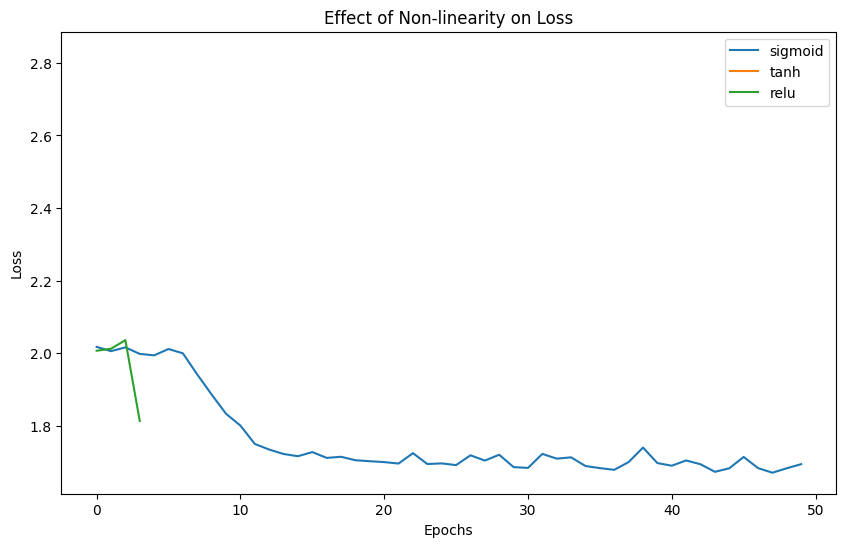

ValueError: operands could not be broadcast together with shapes (4,) (12,64) 

In [33]:
def experiment_activation_functions(X_train, y_train, X_val, y_val):
    activation_functions = ['sigmoid', 'tanh', 'relu']
    losses = []

    for activation in activation_functions:
        mlp=MLP(hidden_layers=[64, 32],
            learning_rate=0.03026,
            activation=activation,
            optimizer='sgd',batch_size=64,
            epochs=50)
        mlp.fit(X_train, y_train)
        losses.append(mlp.losses)  # Assuming you store losses in the fit method

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, loss in enumerate(losses):
        plt.plot(loss, label=activation_functions[i])
    
    plt.title('Effect of Non-linearity on Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def experiment_learning_rates(X_train, y_train, X_val, y_val):
    learning_rates = [0.001, 0.01, 0.1, 1]
    losses = []

    for lr in learning_rates:
        mlp=MLP(hidden_layers=[64, 32],
            learning_rate=learning_rates,
            activation='relu',
            optimizer='sgd',batch_size=64,
            epochs=50)
        mlp.fit(X_train, y_train)
        losses.append(mlp.losses)

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, loss in enumerate(losses):
        plt.plot(loss, label=f'LR: {learning_rates[i]}')
    
    plt.title('Effect of Learning Rate on Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def experiment_batch_sizes(X_train, y_train, X_val, y_val):
    batch_sizes = [16, 32, 64, 128]
    losses = []

    for batch_size in batch_sizes:
        mlp=MLP(hidden_layers=[64, 32],
            learning_rate=0.03026,
            activation='relu',
            optimizer='sgd',batch_size=batch_size,
            epochs=50)
        mlp.fit(X_train, y_train)
        losses.append(mlp.losses)

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, loss in enumerate(losses):
        plt.plot(loss, label=f'Batch Size: {batch_sizes[i]}')
    
    plt.title('Effect of Batch Size on Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # Assuming X_train, y_train, X_val, and y_val are already defined
    experiment_activation_functions(X_train, y_train, X_val, y_val)
    experiment_learning_rates(X_train, y_train, X_val, y_val)
    experiment_batch_sizes(X_train, y_train, X_val, y_val)



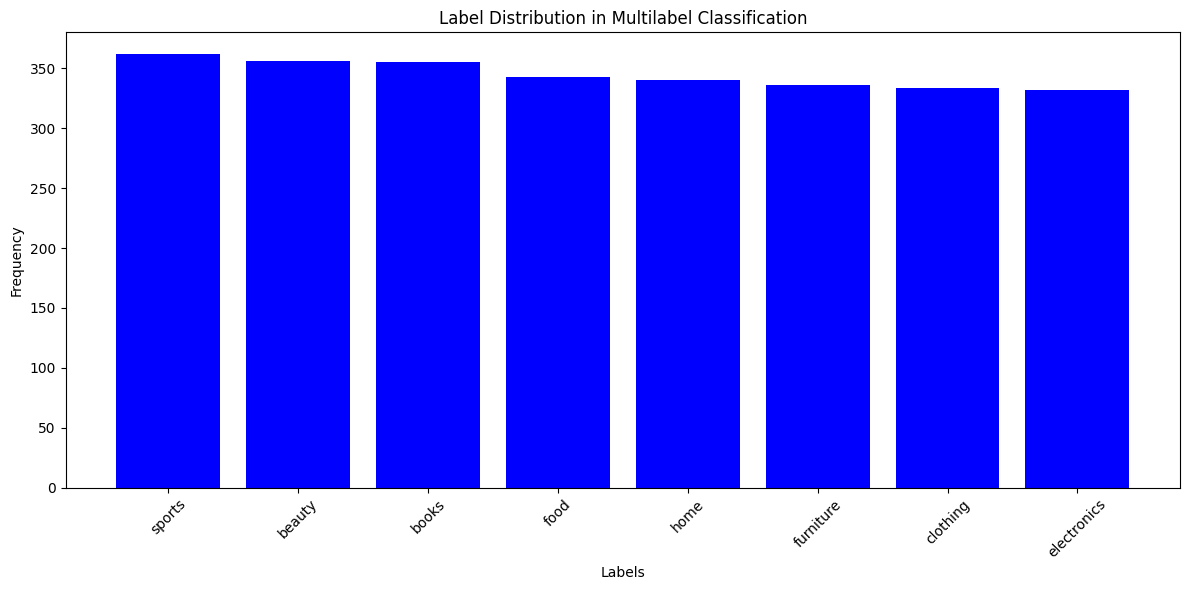

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Step 1: Load the data
file_path = '../../data/external/advertisement.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Step 2: Process the labels
# Assuming the last column contains labels in a string format like "label1 label2 label3"
labels = data.iloc[:, -1].str.get_dummies(sep=' ')  # Convert to one-hot encoding

# Step 3: Count label frequencies
label_counts = labels.sum().sort_values(ascending=False)

# Step 4: Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(label_counts.index, label_counts.values, color='blue')  # Use a single color like 'blue'
plt.xticks(rotation=45)
plt.title('Label Distribution in Multilabel Classification')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


X = data.iloc[:, :-1].values  # Features
y = labels.values  # One-hot encoding for labels

X = data.iloc[:, :-1]
y = data.iloc[:, -1].str.split()

le = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column])

scaler = StandardScaler()
X = scaler.fit_transform(X)

unique_labels = set([label for labels in y for label in labels])
label_to_index = {label: i for i, label in enumerate(unique_labels)}
y_encoded = np.zeros((len(y), len(unique_labels)))
for i, labels in enumerate(y):
    for label in labels:
        y_encoded[i, label_to_index[label]] = 1


X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

class ActivationFunction:
    @staticmethod
    def sigmoid(x, derivative=False):
        sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow
        return sig * (1 - sig) if derivative else sig

    @staticmethod
    def tanh(x, derivative=False):
        t = np.tanh(x)
        return 1 - t**2 if derivative else t

    @staticmethod
    def relu(x, derivative=False):
        return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)

    @staticmethod
    def linear(x, derivative=False):
        return np.ones_like(x) if derivative else x

class Layer:
    def __init__(self, input_size, output_size, activation='relu'):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)  # He initialization
        self.bias = np.zeros((1, output_size))
        self.activation = getattr(ActivationFunction, activation)
        self.dW = np.zeros_like(self.weights)  # Gradient of weights
        self.db = np.zeros_like(self.bias)  # Gradient of bias

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.bias
        return self.activation(self.z)

    def backward(self, delta, learning_rate, optimizer):
        delta = delta * self.activation(self.z, derivative=True)
        self.dW = np.dot(self.inputs.T, delta)
        self.db = np.sum(delta, axis=0, keepdims=True)
        
        if optimizer == 'sgd':
            self.weights -= learning_rate * self.dW
            self.bias -= learning_rate * self.db
        elif optimizer == 'batch':
            return self.dW, self.db
        
        return np.dot(delta, self.weights.T)

class AdvancedMultiLabelMLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, 
                 activation='relu', optimizer='sgd', batch_size=32, epochs=100, early_stopping_pat=5):
        self.layers = []
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping_patience= early_stopping_pat
        
        # Input layer
        self.layers.append(Layer(input_size, hidden_sizes[0], activation))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(Layer(hidden_sizes[i-1], hidden_sizes[i], activation))
        
        # Output layer
        self.layers.append(Layer(hidden_sizes[-1], output_size, 'sigmoid'))

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, X, y, output):
        delta = output - y
        for layer in reversed(self.layers):
            delta = layer.backward(delta, self.learning_rate, self.optimizer)

    def fit(self, X, y, validation_data=None):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                indices = np.random.permutation(len(X))
                X = X[indices]
                y = y[indices]
            
            for i in range(0, len(X), self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                output = self.forward(batch_X)
                self.backward(batch_X, batch_y, output)
            
            # Early stopping
            if validation_data is not None:
                val_X, val_y = validation_data
                val_output = self.predict(val_X)
                val_loss = self.compute_loss(val_y, val_output)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            if (epoch + 1) % 10 == 0:
                loss = self.compute_loss(y, self.predict(X))
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward(X)

    def predict_binary(self, X, threshold=0.5):
        probabilities = self.predict(X)
        return (probabilities >= threshold).astype(int)

    def compute_loss(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

    def gradient_check(self, X, y, epsilon=1e-7):
    # Compute gradients using backpropagation
        output = self.forward(X)
        self.backward(X, y, output)
        
        # Flatten weights and biases separately for easier gradient comparison
        params = []
        grads = []
        for layer in self.layers:
            params.append(layer.weights)
            params.append(layer.bias)
            grads.append(layer.dW)
            grads.append(layer.db)
        
        num_grads = []
        
        for param in params:
            num_grad = np.zeros_like(param)
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                idx = it.multi_index
                old_value = param[idx]
                
                # Compute the cost with the parameter slightly increased
                param[idx] = old_value + epsilon
                cost_plus = self.compute_loss(y, self.forward(X))
                
                # Compute the cost with the parameter slightly decreased
                param[idx] = old_value - epsilon
                cost_minus = self.compute_loss(y, self.forward(X))
                
                # Calculate numerical gradient
                num_grad[idx] = (cost_plus - cost_minus) / (2 * epsilon)
                
                # Reset the parameter value
                param[idx] = old_value
                it.iternext()
            
            num_grads.append(num_grad)
        
        # Compare backprop gradients with numerical gradients
        total_error = 0
        for grad, num_grad in zip(grads, num_grads):
            numerator = np.linalg.norm(grad - num_grad)
            denominator = np.linalg.norm(grad) + np.linalg.norm(num_grad)
            total_error += numerator / (denominator + 1e-7)
        
        average_error = total_error / len(params)
        print(f"Average relative error: {average_error}")
        
        return average_error < 1e-7

    
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].str.split()
    
    le = LabelEncoder()
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = le.fit_transform(X[column])
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    unique_labels = set([label for labels in y for label in labels])
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    y_encoded = np.zeros((len(y), len(unique_labels)))
    for i, labels in enumerate(y):
        for label in labels:
            y_encoded[i, label_to_index[label]] = 1
    
    return X, y_encoded, label_to_index

def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    h_loss = hamming_loss(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Hamming Loss: {h_loss:.4f}')

def calculate_soft_accuracy(y_true, y_pred):
    # Count true positives and true negatives
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    
    total = y_true.shape[0] * y_true.shape[1]  # Total number of predictions
    
    # Calculate soft accuracy
    soft_accuracy = (true_positives + true_negatives) / total
    return soft_accuracy

if __name__ == "__main__":
    # Preprocess data
    # X, y, label_to_index = preprocess_data("advertisement.csv")
    
    # # Split the data
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train the model
    input_size = X_train.shape[1]
    hidden_sizes = [9]  # You can modify this to change the number of hidden layers and neurons
    output_size = y_train.shape[1]
    
    model = AdvancedMultiLabelMLP(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        learning_rate=0.01,
        activation='sigmoid',  # You can change this to 'sigmoid', 'tanh', or 'linear'
        optimizer='sgd',    # You can change this to 'batch' or 'mini-batch'
        batch_size=32,
        epochs=100,
        early_stopping_pat=5
    )
    
    # Train the model with early stopping
    model.fit(X_train, y_train, validation_data=(X_test, y_test))
    
    # Evaluate the model
    y_pred_binary = model.predict_binary(X_test)
    evaluate_model(y_test, y_pred_binary)

    soft_accuracy = calculate_soft_accuracy(y_test, y_pred_binary)
    print(f"\nSoft Accuracy: {soft_accuracy:.4f}")

    print("Performing gradient check...")
    model.gradient_check(X_train[:10], y_train[:10])

Epoch 10/100, Loss: 0.6437
Epoch 20/100, Loss: 0.6370
Epoch 30/100, Loss: 0.6334
Epoch 40/100, Loss: 0.6315
Early stopping at epoch 46
Accuracy: 0.0300
Precision: 0.5862
Recall: 0.0661
F1-score: 0.1189
Hamming Loss: 0.3150

Soft Accuracy: 0.6850
Performing gradient check...
Average relative error: 0.8958998443174107


In [41]:
import wandb

# Initialize a new run at the start of training
def run_experiment(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Preprocess data
        # X, y, label_to_index = preprocess_data("advertisement.csv")
        
        # Split the data
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        input_size = X_train.shape[1]
        output_size = y_train.shape[1]
        
        # Initialize model with hyperparameters from config
        model = AdvancedMultiLabelMLP(
            input_size=input_size,
            hidden_sizes=config.hidden_layers,
            output_size=output_size,
            learning_rate=config.learning_rate,
            activation=config.activation,
            optimizer=config.optimizer,
            batch_size=config.batch_size,
            epochs=config.epochs
        )
        
        # Train the model with early stopping
        model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
        
        # Evaluate the model
        y_pred_binary = model.predict_binary(X_test)
        accuracy = accuracy_score(y_test, y_pred_binary)
        soft_accuracy = calculate_soft_accuracy(y_test, y_pred_binary)
        
        # Log metrics to WandB
        wandb.log({
            "val_accuracy": accuracy,
            "soft_accuracy": soft_accuracy
        })

        print(f"Accuracy: {accuracy:.4f}, Soft Accuracy: {soft_accuracy:.4f}")

# Define the sweep configuration
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'soft_accuracy'},
    'parameters': 
    {
        'hidden_layers': {'values': [[9], [10, 8], [64, 32]]},
        'learning_rate': {'min': 0.0001, 'max': 0.1},
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},
        'optimizer': {'values': ['sgd', 'batch', 'mini_batch']},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [50, 100, 150]},
        'early_stopping_patience': {'values': [5, 10, 15]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_configuration, project="multi_label_mlp")

# Run the sweep
wandb.agent(sweep_id, function=run_experiment)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: s3ry7u83
Sweep URL: https://wandb.ai/dusaneyash09-iiit-hyderabad/multi_label_mlp/sweeps/s3ry7u83


wandb: Agent Starting Run: cat5g7f7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	early_stopping_patience: 15
wandb: 	epochs: 150
wandb: 	hidden_layers: [9]
wandb: 	learning_rate: 0.08163558451502814
wandb: 	optimizer: sgd
wandb: Currently logged in as: dusaneyash09 (dusaneyash09-iiit-hyderabad). Use `wandb login --relogin` to force relogin


Epoch 10/150, Loss: 2.5259
Early stopping at epoch 17
Accuracy: 0.0100, Soft Accuracy: 0.6687


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.66875
val_accuracy,0.01


wandb: Agent Starting Run: 1jefbm0c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	early_stopping_patience: 15
wandb: 	epochs: 100
wandb: 	hidden_layers: [64, 32]
wandb: 	learning_rate: 0.02752306460231159
wandb: 	optimizer: mini_batch


Epoch 10/100, Loss: 0.8858
Early stopping at epoch 16
Accuracy: 0.0000, Soft Accuracy: 0.4650


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.465
val_accuracy,0


wandb: Agent Starting Run: ke1fnc7b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	early_stopping_patience: 5
wandb: 	epochs: 50
wandb: 	hidden_layers: [9]
wandb: 	learning_rate: 0.0039115625804875855
wandb: 	optimizer: batch


Traceback (most recent call last):
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogen

Run ke1fnc7b errored:
Traceback (most recent call last):
  File "c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Traceback (most recent call last):
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogen

Run ehgut3bc errored:
Traceback (most recent call last):
  File "c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10/50, Loss: 0.8726
Early stopping at epoch 16
Accuracy: 0.0000, Soft Accuracy: 0.4913


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.49125
val_accuracy,0


wandb: Agent Starting Run: 7smsgize with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	early_stopping_patience: 10
wandb: 	epochs: 50
wandb: 	hidden_layers: [64, 32]
wandb: 	learning_rate: 0.030853775563808535
wandb: 	optimizer: mini_batch


Epoch 10/50, Loss: 0.8115
Early stopping at epoch 11
Accuracy: 0.0100, Soft Accuracy: 0.5225


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.5225
val_accuracy,0.01


wandb: Agent Starting Run: 9jjp5rzn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	early_stopping_patience: 10
wandb: 	epochs: 150
wandb: 	hidden_layers: [9]
wandb: 	learning_rate: 0.03210959839945258
wandb: 	optimizer: sgd


Epoch 10/150, Loss: 0.6269
Early stopping at epoch 18
Accuracy: 0.0200, Soft Accuracy: 0.6663


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.66625
val_accuracy,0.02


wandb: Agent Starting Run: 5wqjz7px with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	early_stopping_patience: 15
wandb: 	epochs: 100
wandb: 	hidden_layers: [10, 8]
wandb: 	learning_rate: 0.07806959556823369
wandb: 	optimizer: mini_batch


Epoch 10/100, Loss: 0.9593
Early stopping at epoch 16
Accuracy: 0.0100, Soft Accuracy: 0.5225


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.5225
val_accuracy,0.01


wandb: Agent Starting Run: m2rfhiw2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	early_stopping_patience: 5
wandb: 	epochs: 50
wandb: 	hidden_layers: [9]
wandb: 	learning_rate: 0.012338327813370603
wandb: 	optimizer: sgd


Epoch 10/50, Loss: 0.6330
Epoch 20/50, Loss: 0.6270
Early stopping at epoch 26
Accuracy: 0.0600, Soft Accuracy: 0.6887


soft_accuracy,▁
val_accuracy,▁
soft_accuracy,0.68875
val_accuracy,0.06


wandb: Agent Starting Run: y1grrngq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	early_stopping_patience: 15
wandb: 	epochs: 50
wandb: 	hidden_layers: [10, 8]
wandb: 	learning_rate: 0.06652211040123382
wandb: 	optimizer: batch


Traceback (most recent call last):
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogen

Run y1grrngq errored:
Traceback (most recent call last):
  File "c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\1641884746.py", line 30, in run_experiment
    model.fit(X_train, y_train, validation_data=(X_test, y_test), early_stopping_patience=config.early_stopping_patience)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 96, in fit
    self.backward(batch_X, batch_y, output)
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 79, in backward
    delta = layer.backward(delta, self.learning_rate, self.optimizer)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yashd\AppData\Local\Temp\ipykernel_3288\2170164406.py", line 40, in backward
    delta = delta * self.activation(self.z, derivative=True)
            ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [56]:
model = AdvancedMultiLabelMLP(
        input_size=input_size,
        hidden_sizes=[9],
        output_size=output_size,
        learning_rate=0.01234,
        activation='relu',  # You can change this to 'sigmoid', 'tanh', or 'linear'
        optimizer='sgd',    # You can change this to 'batch' or 'mini-batch'
        batch_size=16,
        epochs=50,
        early_stopping_pat=5
    )
    
# Train the model with early stopping
model.fit(X_train, y_train, validation_data=(X_test, y_test))

# Evaluate the model
y_pred_binary = model.predict_binary(X_test)
evaluate_model(y_test, y_pred_binary)

soft_accuracy = calculate_soft_accuracy(y_test, y_pred_binary)
print(f"\nSoft Accuracy: {soft_accuracy:.4f}")

# print("Performing gradient check...")
# model.gradient_check(X_train[:10], y_train[:10])

Epoch 10/50, Loss: 0.6333
Epoch 20/50, Loss: 0.6284
Epoch 30/50, Loss: 0.6252
Epoch 40/50, Loss: 0.6221
Early stopping at epoch 42
Accuracy: 0.0500
Precision: 0.5085
Recall: 0.1167
F1-score: 0.1899
Hamming Loss: 0.3200

Soft Accuracy: 0.6800


---------------

### Question 3 MLP Regression

-------------

          NOX          RM        DIS             RAD         TAX     PTRATIO   \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     0.554695    6.284634    3.795043    9.549407  408.237154   18.455534   
std      0.115878    0.702617    2.105710    8.707259  168.537116    2.164946   
min      0.385000    3.561000    1.129600    1.000000  187.000000   12.600000   
25%      0.449000    5.885500    2.100175    4.000000  279.000000   17.400000   
50%      0.538000    6.208500    3.207450    5.000000  330.000000   19.050000   
75%      0.624000    6.623500    5.188425   24.000000  666.000000   20.200000   
max      0.871000    8.780000   12.126500   24.000000  711.000000   22.000000   

          B              MEDV  
count  506.000000  506.000000  
mean   356.674032   22.532806  
std     91.294864    9.197104  
min      0.320000    5.000000  
25%    375.377500   17.025000  
50%    391.440000   21.200000  
75%    396.225000   25.000000  
max    396.900

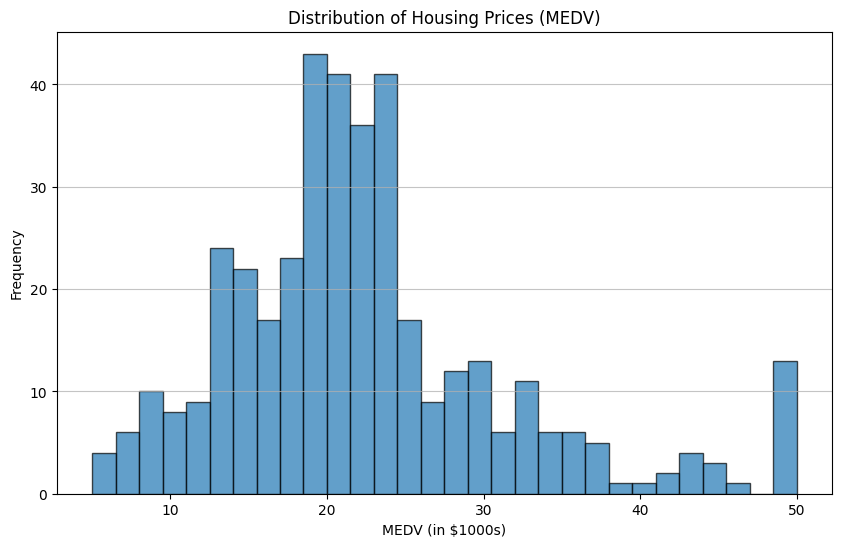

Train set: (236, 14)
Validation set: (79, 14)
Test set: (79, 14)
Scaled training data mean: [-1.12904036e-17 -2.25808073e-17  7.52693576e-17  6.02154861e-17
  1.50538715e-16 -1.23441746e-15  1.65592587e-16  5.26885503e-17
 -6.02154861e-17 -1.12904036e-16  1.27957908e-15 -1.58065651e-16
 -1.65592587e-16]
Scaled training data std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [34]:
import pandas as pd

# Load the dataset from CSV
df = pd.read_csv('../../data/external/HousingData.csv')

# Describe the dataset
description = df.describe()
print(description)

# Replace 'NA' with NaN
df.replace('NA', pd.NA, inplace=True)

# Convert relevant columns to numeric (if they aren't already)
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Drop rows with missing values
df = df.dropna()

# Check again for missing values
missing_values_after = df.isnull().sum()
print("Missing values after handling:\n", missing_values_after)


import matplotlib.pyplot as plt

# Plot the distribution of MEDV
plt.figure(figsize=(10, 6))
plt.hist(df['MEDV'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Housing Prices (MEDV)')
plt.xlabel('MEDV (in $1000s)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
train_val, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Check the shapes of the splits
print(f'Train set: {train.shape}')
print(f'Validation set: {val.shape}')
print(f'Test set: {test.shape}')

from sklearn.preprocessing import StandardScaler

# Separating features and target
X_train = train.drop('MEDV', axis=1)
y_train = train['MEDV']
X_val = val.drop('MEDV', axis=1)
y_val = val['MEDV']
X_test = test.drop('MEDV', axis=1)
y_test = test['MEDV']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Check the scaled values
print(f'Scaled training data mean: {X_train.mean(axis=0)}')
print(f'Scaled training data std: {X_train.std(axis=0)}')


In [8]:
import numpy as np

class MLPRegression:
    def __init__(self, layers, learning_rate=0.01, activation='relu', optimizer='sgd', batch_size=32, epochs=100):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_func = self.get_activation_func(activation)
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.weights, self.biases = self.initialize_weights()
    
    def initialize_weights(self):
        np.random.seed(42)
        weights = []
        biases = []
        for i in range(1, len(self.layers)):
            weights.append(np.random.randn(self.layers[i], self.layers[i - 1]) * 0.01)
            biases.append(np.zeros((self.layers[i], 1)))
        return weights, biases

    def get_activation_func(self, name):
        if name == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-np.clip(x, -500, 500))), lambda x: x * (1 - x)  # Clipping the input to avoid overflow
        elif name == 'tanh':
            return lambda x: np.tanh(x), lambda x: 1 - x ** 2  # Tanh & derivative
        elif name == 'relu':
            return lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)  # ReLU & derivative
        elif name == 'linear':
            return lambda x: x, lambda x: 1  # Linear (for regression)
    x: 1  # Linear (for regression)

    def forward(self, X):
        a = X.T
        activations = [a]
        z_values = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, a) + b
            a = self.activation_func[0](z)
            z_values.append(z)
            activations.append(a)
        return activations, z_values

    def backprop(self, activations, z_values, y):
        m = y.shape[0]
        dz = activations[-1] - y.T
        dws = []
        dbs = []
        for i in reversed(range(len(self.weights))):
            dw = (1/m) * np.dot(dz, activations[i].T)
            db = (1/m) * np.sum(dz, axis=1, keepdims=True)

            # Gradient Clipping: Limit the values of dw and db to a certain threshold
            np.clip(dw, -1e5, 1e5, out=dw)
            np.clip(db, -1e5, 1e5, out=db)

            dws.insert(0, dw)
            dbs.insert(0, db)
            if i > 0:
                dz = np.dot(self.weights[i].T, dz) * self.activation_func[1](z_values[i-1])  # Backpropagate
        return dws, dbs


    def update_weights(self, dws, dbs):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dws[i]
            self.biases[i] -= self.learning_rate * dbs[i]

    def update_weights_batch(self, X_train, y_train):
 
        y_train = np.array(y_train).reshape(-1, 1)

        for epoch in range(self.epochs):
            activations, z_values = self.forward(X_train)
            dws, dbs = self.backprop(activations, z_values, y_train)
            self.update_weights(dws, dbs)


    def update_weights_mini_batch(self, X_train, y_train):
        for epoch in range(self.epochs):
            for start_idx in range(0, len(X_train), self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_train[start_idx:end_idx]
                y_batch = np.array(y_train[start_idx:end_idx]).reshape(-1, 1)  # Ensure proper shape

                activations, z_values = self.forward(X_batch)
                dws, dbs = self.backprop(activations, z_values, y_batch)
                self.update_weights(dws, dbs)


    def fit(self, X_train, y_train):
        if self.optimizer == 'sgd':
            self.update_weights_batch(X_train, y_train)
        elif self.optimizer == 'batch':
            self.update_weights_batch(X_train, y_train)
        elif self.optimizer == 'mini_batch':
            self.update_weights_mini_batch(X_train, y_train)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].T

    def evaluate(self, X, y):
        y = np.array(y).reshape(-1, 1)
        y_pred = self.predict(X)

        # Ensure no divide by zero in loss calculation
        mae = np.mean((y - y_pred))
        mse = np.mean((y - y_pred) ** 2)
        if np.isnan(mse) or np.isinf(mse):
            print("MSE computation resulted in NaN or Inf.")
            mse = np.nan_to_num(mse, nan=1e6, posinf=1e6, neginf=-1e6)  # Avoid NaN or Inf by substituting large values
        rmse = np.sqrt(mse)
        r2 = 1 - (np.sum((y - y_pred) ** 2) / (np.sum((y - np.mean(y)) ** 2) + 1e-8))  # Small epsilon to avoid division by zero
        return mse, rmse, r2, mae


    def gradient_check(self, X, y, epsilon=1e-7):
        activations, _ = self.forward(X)
        dws, dbs = self.backprop(activations, None, y)
        
        # Gradient checking for weights
        for i in range(len(self.weights)):
            original_weights = self.weights[i].copy()
            num_grads_w = np.zeros_like(self.weights[i])
            
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss1 = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss2 = self._compute_loss(X, y)
                    
                    num_grads_w[j, k] = (loss1 - loss2) / (2 * epsilon)
                    self.weights[i][j, k] = original_weights[j, k]  # Reset
            
            assert np.allclose(dws[i], num_grads_w, atol=1e-5), f"Gradient check failed for layer {i}"
        
        print("Gradient check passed for weights")

    def _compute_loss(self, X, y):
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)


# Define the architecture of the MLP
layers = [X_train.shape[1], 64, 32, 1]  # Input layer, two hidden layers, output layer

# Create an instance of the MLPRegression class
mlp = MLPRegression(layers=layers, learning_rate=0.01, activation='relu', optimizer='sgd', batch_size=32, epochs=100)

# Train the model
mlp.fit(X_train, y_train)

# Evaluate on validation set
mse_val, rmse_val, r2_val, mae_val = mlp.evaluate(X_val, y_val)
print(f'Validation MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}')

# mlp.gradient_check(X_val[:10], y_val[:10])
# # Evaluate on test set
# mse_test, rmse_test, r2_test = mlp.evaluate(X_test, y_test)
# print(f'Test MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}')


Validation MSE: 3.1579, RMSE: 1.7770, R²: -5.8537


In [9]:
# Define the architecture of the MLP
layers = [X_train.shape[1], 13, 10, 1]  # Input layer, two hidden layers, output layer

# Create an instance of the MLPRegression class
mlp = MLPRegression(layers=layers, learning_rate=0.01935, activation='relu', optimizer='batch', batch_size=64, epochs=50)

# Train the model
mlp.fit(X_train, y_train)

# Evaluate on validation set
mse_test, rmse_test, r2_test, mae_test = mlp.evaluate(X_test, y_test)
print(f'Validation MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}, MAE: {mae_test:.4f}')

Validation MSE: 5.2147, RMSE: 2.2836, R²: -7.0248, MAE: 2.1366


In [32]:
import wandb 

sweep_config = {
    'method': 'random',  # 'random', 'grid', or 'bayes'
    'metric': {
        'name': 'MSE',
        'goal': 'minimize'  # We want to minimize MSE
    },
    'parameters': {
        'learning_rate': {'min': 0.0001, 'max': 0.1},
        'optimizer': {
            'values': ['sgd', 'batch', 'mini-batch']  # Testing SGD and Adam
        },
        'activation': {
            'values': ['relu', 'tanh', 'sigmoid']  # Trying different activation functions
        },
        'batch_size': {
            'values': [16, 32, 64]  # Different batch sizes
        },
        'epochs': {
            'values': [50, 100, 200]  # Number of epochs
        },
        'layers': {
            'values': [[X_train.shape[1], 64, 32, 1], [X_train.shape[1], 10, 1], [X_train.shape[1], 32, 16, 1]]  # Different network architectures
        }
    }
}

def sweep_train():
    # Initialize a new run
    wandb.init()

    # Get hyperparameters from the W&B config
    config = wandb.config

    # Create the MLP model with hyperparameters from the sweep config
    mlp = MLPRegression(
        layers=config.layers,
        learning_rate=config.learning_rate,
        activation=config.activation,
        optimizer=config.optimizer,
        batch_size=config.batch_size,
        epochs=config.epochs
    )

    # Train the model
    mlp.fit(X_train, y_train)

    # Evaluate the model on the validation set
    mse, rmse, r2 = mlp.evaluate(X_val, y_val)

    # Log metrics to W&B
    wandb.log({"MSE": mse, "RMSE": rmse, "R²": r2})

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="MLP-Regression-Sweep")

# Run the sweep
wandb.agent(sweep_id, function=sweep_train, count=20)  # count defines how many runs to execute


Create sweep with ID: 6gjni9g3
Sweep URL: https://wandb.ai/dusaneyash09-iiit-hyderabad/MLP-Regression-Sweep/sweeps/6gjni9g3


wandb: Agent Starting Run: 2mzfq1hq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.09225654079334918
wandb: 	optimizer: batch


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: dgf9fcn8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	layers: [13, 32, 16, 1]
wandb: 	learning_rate: 0.08341886725752752
wandb: 	optimizer: batch


MSE,▁
RMSE,▁
R²,▁
MSE,558.94177
RMSE,23.64195
R²,-6.11037


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p3ukgzfi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.08816095445399691
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: oebasmcm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.022746996895633448
wandb: 	optimizer: mini-batch


MSE,▁
RMSE,▁
R²,▁
MSE,551.75188
RMSE,23.4894
R²,-6.01891


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7r5jrenn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.022622509146604287
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: qv3nndxv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.0634118654732294
wandb: 	optimizer: mini-batch


MSE,▁
RMSE,▁
R²,▁
MSE,573.6121
RMSE,23.9502
R²,-6.297


wandb: Agent Starting Run: gvindu8r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 32, 16, 1]
wandb: 	learning_rate: 0.026090165504999537
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: byvh1v7c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 32, 16, 1]
wandb: 	learning_rate: 0.02380411341148807
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,25.12549
RMSE,5.01253
R²,0.68038


wandb: Agent Starting Run: 3obxywbh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 200
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.007428424607899751
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: b3qbfaaw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.097716266337565
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,573.58734
RMSE,23.94968
R²,-6.29668


wandb: Agent Starting Run: a3nspoae with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 100
wandb: 	layers: [13, 32, 16, 1]
wandb: 	learning_rate: 0.013550020920275569
wandb: 	optimizer: mini-batch


MSE,▁
RMSE,▁
R²,▁
MSE,573.58667
RMSE,23.94967
R²,-6.29667


wandb: Agent Starting Run: 06dwgv6s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.01934728134045288
wandb: 	optimizer: batch


MSE,▁
RMSE,▁
R²,▁
MSE,21.15975
RMSE,4.59997
R²,0.73082


wandb: Agent Starting Run: 70oy0av4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.05052759707114166
wandb: 	optimizer: batch


MSE,▁
RMSE,▁
R²,▁
MSE,530.27326
RMSE,23.02766
R²,-5.74568


wandb: Agent Starting Run: up0g05ld with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.0843309949424094
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,559.98481
RMSE,23.664
R²,-6.12364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8v2kwsbc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.06707557464991765
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: 2ikpb1l8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.016058995808151313
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,530.09114
RMSE,23.02371
R²,-5.74336


wandb: Agent Starting Run: e87usajq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.02050334695216944
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,557.57468
RMSE,23.61302
R²,-6.09298


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yanqswuf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	layers: [13, 64, 32, 1]
wandb: 	learning_rate: 0.024765625744138348
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,34.83694
RMSE,5.90228
R²,0.55683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zk8llvoy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.03193106311725523
wandb: 	optimizer: mini-batch


MSE,▁
RMSE,▁
R²,▁
MSE,573.6121
RMSE,23.9502
R²,-6.297


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: blf4vjvs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	layers: [13, 10, 1]
wandb: 	learning_rate: 0.07692526846857653
wandb: 	optimizer: sgd


MSE,▁
RMSE,▁
R²,▁
MSE,557.57468
RMSE,23.61302
R²,-6.09298


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('../../data/external/diabetes.csv')

X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values   # Last column


X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Epoch 0, Loss: 0.6936022302506661
Epoch 10, Loss: 0.6905839921135517
Epoch 20, Loss: 0.6876212131673527
Epoch 30, Loss: 0.6847128094010263
Epoch 40, Loss: 0.6818577098537895
Epoch 50, Loss: 0.6790548571162606
Epoch 60, Loss: 0.6763032077838926
Epoch 70, Loss: 0.6736017328640045
Epoch 80, Loss: 0.6709494181378285
Epoch 90, Loss: 0.6683452644790988
Epoch 100, Loss: 0.6657882881307827
Epoch 110, Loss: 0.6632775209416332
Epoch 120, Loss: 0.6608120105642898
Epoch 130, Loss: 0.6583908206166984
Epoch 140, Loss: 0.6560130308086466
Epoch 150, Loss: 0.6536777370352286
Epoch 160, Loss: 0.6513840514390549
Epoch 170, Loss: 0.6491311024430161
Epoch 180, Loss: 0.646918034755396
Epoch 190, Loss: 0.6447440093491013
Epoch 200, Loss: 0.6426082034167473
Epoch 210, Loss: 0.6405098103032957
Epoch 220, Loss: 0.6384480394178997
Epoch 230, Loss: 0.6364221161265613
Epoch 240, Loss: 0.6344312816271505
Epoch 250, Loss: 0.6324747928082832
Epoch 260, Loss: 0.6305519220934906
Epoch 270, Loss: 0.6286619572720563
Epoc

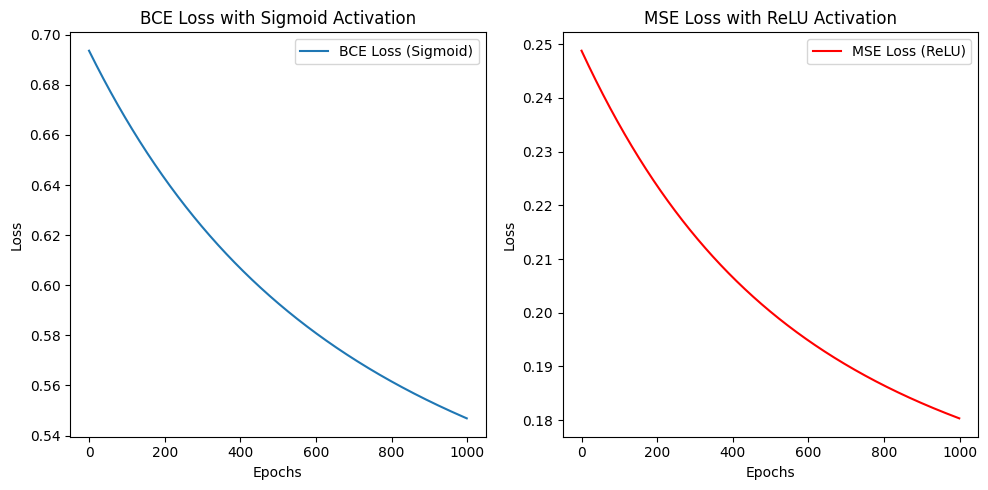

In [11]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# # import wandb
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# class MLPBinaryClassifier:
#     def __init__(self, input_size, learning_rate=0.01, loss_type='bce', epochs=100):
#         self.learning_rate = learning_rate
#         self.loss_type = loss_type
#         self.epochs = epochs
#         self.weights = np.random.randn(input_size, 1) * 0.01
#         self.bias = np.zeros((1, 1))
#         self.losses = []

#     def sigmoid(self, z):
#         return 1 / (1 + np.exp(-z))

#     def forward(self, X):
#         z = np.dot(X, self.weights) + self.bias
#         return self.sigmoid(z)

#     def compute_loss(self, A, y):
#         m = y.shape[0]
#         if self.loss_type == 'bce':
#             loss = -1/m * (np.dot(y.T, np.log(A)) + np.dot((1 - y).T, np.log(1 - A)))
#         elif self.loss_type == 'mse':
#             loss = np.mean((A - y) ** 2)
#         return loss.item()  # Return as scalar

#     def backprop(self, X, A, y):
#         m = y.shape[0]
#         dz = A - y
#         dw = (1/m) * np.dot(X.T, dz)
#         db = (1/m) * np.sum(dz)
#         return dw, db

#     def update_weights(self, dw, db):
#         self.weights -= self.learning_rate * dw
#         self.bias -= self.learning_rate * db

#     def fit(self, X, y):
#         y = y.reshape(-1, 1)
#         for epoch in range(self.epochs):
#             A = self.forward(X)
#             loss = self.compute_loss(A, y)
#             self.losses.append(loss)
#             dw, db = self.backprop(X, A, y)
#             self.update_weights(dw, db)

#             if epoch % 10 == 0:
#                 print(f'Epoch {epoch}, Loss: {loss}')
#                 # wandb.log({"loss": loss})  # Log to WandB

#     def predict(self, X):
#         A = self.forward(X)
#         return (A > 0.5).astype(int)

# # # # Initialize WandB
# # wandb.init(project='diabetes-classification', entity='your_entity_name')

# # Train models
# model_bce = MLPBinaryClassifier(input_size=X_train.shape[1], learning_rate=0.01, loss_type='bce', epochs=200)
# model_bce.fit(X_train, y_train)

# model_mse = MLPBinaryClassifier(input_size=X_train.shape[1], learning_rate=0.01, loss_type='mse', epochs=200)
# model_mse.fit(X_train, y_train)

# # Predict and evaluate
# y_pred_bce = model_bce.predict(X_test)
# y_pred_mse = model_mse.predict(X_test)

# accuracy_bce = np.mean(y_pred_bce.flatten() == y_test)
# accuracy_mse = np.mean(y_pred_mse.flatten() == y_test)

# print(f'Accuracy with BCE Loss: {accuracy_bce:.2f}')
# print(f'Accuracy with MSE Loss: {accuracy_mse:.2f}')

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(model_bce.losses, label='BCE Loss')
# plt.title('BCE Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(model_mse.losses, label='MSE Loss', color='red')
# plt.title('MSE Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()




import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

# data = pd.read_csv('diabetes.csv')

X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values   # Last column


X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


class MLPBinary:
    def __init__(self, input_size, learning_rate=0.01, loss_type='bce', epochs=100, activation='sigmoid'):
        self.learning_rate = learning_rate
        self.loss_type = loss_type
        self.epochs = epochs
        self.activation = activation
        self.weights = np.random.randn(input_size, 1) * 0.01
        self.bias = np.zeros((1, 1))
        self.losses = []

    # Activation functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def tanh(self, z):
        return np.tanh(z)

    # Derivatives for activation functions (needed for backprop)
    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def tanh_derivative(self, z):
        return 1 - np.tanh(z) ** 2

    # Forward pass based on selected activation function
    def forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        if self.activation == 'sigmoid':
            return self.sigmoid(z)
        elif self.activation == 'relu':
            return self.relu(z)
        elif self.activation == 'tanh':
            return self.tanh(z)

    def compute_loss(self, A, y):
        m = y.shape[0]
        if self.loss_type == 'bce':
            loss = -np.mean(y * np.log(A) + (1 - y) * np.log(1 - A))
        elif self.loss_type == 'mse':
            loss = np.mean((A - y) ** 2)
        return loss

    def backprop(self, X, A, y):
        m = y.shape[0]
        dz = A - y  # Derivative of loss w.r.t activation output

        # Derivative of activation function
        if self.activation == 'sigmoid':
            dz *= self.sigmoid_derivative(A)
        elif self.activation == 'relu':
            dz *= self.relu_derivative(A)
        elif self.activation == 'tanh':
            dz *= self.tanh_derivative(A)

        dw = (1/m) * np.dot(X.T, dz)
        db = (1/m) * np.sum(dz)
        return dw, db

    def update_weights(self, dw, db):
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        for epoch in range(self.epochs):
            A = self.forward(X)
            loss = self.compute_loss(A, y)
            self.losses.append(loss)
            dw, db = self.backprop(X, A, y)
            self.update_weights(dw, db)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, X):
        A = self.forward(X)
        return (A > 0.5).astype(int)


# Now, you can test with different activation functions

# Model with BCE loss and sigmoid activation
model_bce_sigmoid = MLPBinary(input_size=X_train.shape[1], learning_rate=0.01, loss_type='bce', epochs=1000, activation='sigmoid')
model_bce_sigmoid.fit(X_train, y_train)

# Model with MSE loss and relu activation
model_mse_relu = MLPBinary(input_size=X_train.shape[1], learning_rate=0.01, loss_type='mse', epochs=1000, activation='sigmoid')
model_mse_relu.fit(X_train, y_train)

# Predict and evaluate
y_pred_bce_sigmoid = model_bce_sigmoid.predict(X_test)
y_pred_mse_relu = model_mse_relu.predict(X_test)

accuracy_bce_sigmoid = np.mean(y_pred_bce_sigmoid.flatten() == y_test)
accuracy_mse_relu = np.mean(y_pred_mse_relu.flatten() == y_test)

print(f'Accuracy with BCE Loss (Sigmoid): {accuracy_bce_sigmoid:.2f}')
print(f'Accuracy with MSE Loss (Sigmoid): {accuracy_mse_relu:.2f}')

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(model_bce_sigmoid.losses, label='BCE Loss (Sigmoid)')
plt.title('BCE Loss with Sigmoid Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_mse_relu.losses, label='MSE Loss (ReLU)', color='red')
plt.title('MSE Loss with ReLU Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

--------------

### AutoEncoders

--------------

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the Dataset
data = pd.read_csv('../../data/external/spotify.csv')

# Step 3: Select Numeric Columns (6 to 20, excluding column 8)
numeric_data = data.iloc[:, [6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

# Step 4: Remove Invalid Values
numeric_data = numeric_data.apply(pd.to_numeric, errors='coerce').dropna()

# Step 5: Split into Input and Output
output_column = data.iloc[numeric_data.index, -1]  # Assuming the output column is now the last one
X = numeric_data  # Input features with the output column removed
y = output_column.reset_index(drop=True)  # Output labels

# Step 7: Standardize Remaining Data
scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X)

# Step 8: Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X_standardized, y, test_size=0.2, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validate shape:", X_validate.shape)
print("y_validate shape:", y_validate.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (91200, 13)
y_train shape: (91200,)
X_validate shape: (11400, 13)
y_validate shape: (11400,)
X_test shape: (11400, 13)
y_test shape: (11400,)


In [104]:
import numpy as np

class AutoEncoder:
    def __init__(self, input_size, hidden_size, activation='relu', optimizer='sgd', learning_rate=0.01, batch_size=32, epochs=100):
        # Initialize weights and biases for encoder and decoder
        self.encoder_weights = np.random.randn(input_size, hidden_size) * 0.01
        self.encoder_bias = np.zeros((1, hidden_size))
        self.decoder_weights = np.random.randn(hidden_size, input_size) * 0.01
        self.decoder_bias = np.zeros((1, input_size))
        self.learning_rate = learning_rate
        self.activation = self.get_activation_func(activation)
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size

    def get_activation_func(self, name):
        if name == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x)  # Sigmoid and its derivative
        elif name == 'tanh':
            return lambda x: np.tanh(x), lambda x: 1 - x ** 2  # Tanh and its derivative
        elif name == 'relu':
            return lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)  # ReLU and its derivative
        elif name == 'linear':
            return lambda x: x, lambda x: 1  # Linear activation (for reconstruction)

    def forward(self, X):
        # Encoder forward pass
        self.z1 = np.dot(X, self.encoder_weights) + self.encoder_bias
        self.a1 = self.activation[0](self.z1)
        
        # Decoder forward pass (reconstruction)
        self.z2 = np.dot(self.a1, self.decoder_weights) + self.decoder_bias
        self.a2 = self.activation[0](self.z2)
        
        return self.a2

    def backprop(self, X, reconstruction):
        m = X.shape[0]
        
        # Compute reconstruction error
        dz2 = (reconstruction - X) * self.activation[1](reconstruction)
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        dz1 = np.dot(dz2, self.decoder_weights.T) * self.activation[1](self.a1)
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        return dw1, db1, dw2, db2

    def update_weights(self, dw1, db1, dw2, db2):
        self.encoder_weights -= self.learning_rate * dw1
        self.encoder_bias -= self.learning_rate * db1
        self.decoder_weights -= self.learning_rate * dw2
        self.decoder_bias -= self.learning_rate * db2

    def fit_sgd(self, X):
        # Training using Stochastic Gradient Descent (SGD)
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # Forward pass
                x_single = X[i:i+1]  # Single example
                reconstruction = self.forward(x_single)
                
                # Backpropagation
                dw1, db1, dw2, db2 = self.backprop(x_single, reconstruction)
                
                # Update weights
                self.update_weights(dw1, db1, dw2, db2)

    def fit_batch(self, X):
        # Training using Batch Gradient Descent
        for epoch in range(self.epochs):
            reconstruction = self.forward(X)
            dw1, db1, dw2, db2 = self.backprop(X, reconstruction)
            self.update_weights(dw1, db1, dw2, db2)

    def fit_mini_batch(self, X):
        # Training using Mini-Batch Gradient Descent
        for epoch in range(self.epochs):
            for start_idx in range(0, X.shape[0], self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X[start_idx:end_idx]
                
                # Forward pass
                reconstruction = self.forward(X_batch)
                
                # Backpropagation
                dw1, db1, dw2, db2 = self.backprop(X_batch, reconstruction)
                
                # Update weights
                self.update_weights(dw1, db1, dw2, db2)

    def fit(self, X):
        if self.optimizer == 'sgd':
            self.fit_sgd(X)
        elif self.optimizer == 'batch':
            self.fit_batch(X)
        elif self.optimizer == 'mini_batch':
            self.fit_mini_batch(X)

    def get_latent(self, X):
        # Return the encoded (compressed) data
        return self.activation[0](np.dot(X, self.encoder_weights) + self.encoder_bias)

    def reconstruct(self, X):
        # Perform a forward pass to reconstruct the data
        return self.forward(X)



# Example usage:
input_size = X_train.shape[1]  # Number of input features
hidden_size = 8  # Latent space size

# Initialize the autoencoder with ReLU activation and Mini-Batch Gradient Descent
autoencoder = AutoEncoder(input_size, hidden_size, activation='relu', optimizer='batch', learning_rate=0.01, batch_size=32, epochs=100)

# Train the autoencoder
autoencoder.fit(X_train)

# Obtain the reduced (latent) dataset
latent_train = autoencoder.get_latent(X_train)
latent_test = autoencoder.get_latent(X_test)

In [89]:
import numpy as np

class MLPRegression:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01):
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

        self.learning_rate = learning_rate
        self.activation = self.get_activation_func(activation)

    def get_activation_func(self, name):
        if name == 'sigmoid':
            return (lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x))  # Sigmoid and its derivative
        elif name == 'tanh':
            return (lambda x: np.tanh(x), lambda x: 1 - x ** 2)  # Tanh and its derivative
        elif name == 'relu':
            return (lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0))  # ReLU and its derivative
        elif name == 'linear':
            return (lambda x: x, lambda x: 1)  # Linear activation (for reconstruction)

    def forward(self, X):
        self.a = X
        self.zs = []  # Store z values for backpropagation
        for weight, bias in zip(self.weights, self.biases):
            z = np.dot(self.a, weight) + bias
            self.zs.append(z)
            self.a = self.activation[0](z)  # Apply activation function
        return self.a

    def backprop(self, X, output):
        m = X.shape[0]  # Number of examples
        dz = (output - X) * self.activation[1](output)  # Shape: (m, output_size)

        dws = []
        dbs = []

        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.a.T, dz) / m  # Shape: (previous_layer_size, output_size)
            db = np.sum(dz, axis=0, keepdims=True) / m  # Shape: (1, output_size)
            dws.append(dw)
            dbs.append(db)

            if i > 0:  # Don't backpropagate through the input layer
                dz = np.dot(dz, self.weights[i].T) * self.activation[1](self.zs[i - 1])  # Shape: (m, hidden_size)

        return list(reversed(dws)), list(reversed(dbs))

    def update_weights(self, dws, dbs):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dws[i]
            self.biases[i] -= self.learning_rate * dbs[i]

    def fit(self, X, optimizer='sgd', batch_size=32, epochs=100):
        if optimizer == 'sgd':
            self.fit_sgd(X, epochs)
        elif optimizer == 'batch':
            self.fit_batch(X, epochs)
        elif optimizer == 'mini_batch':
            self.fit_mini_batch(X, batch_size, epochs)

    def fit_sgd(self, X, epochs):
        for epoch in range(epochs):
            for i in range(X.shape[0]):
                x_single = X[i:i + 1]  # Shape: (1, input_size)
                output = self.forward(x_single)
                dws, dbs = self.backprop(x_single, output)
                self.update_weights(dws, dbs)

    def fit_batch(self, X, epochs):
        for epoch in range(epochs):
            output = self.forward(X)
            dws, dbs = self.backprop(X, output)
            self.update_weights(dws, dbs)

    def fit_mini_batch(self, X, batch_size, epochs):
        for epoch in range(epochs):
            for start_idx in range(0, X.shape[0], batch_size):
                end_idx = start_idx + batch_size
                X_batch = X[start_idx:end_idx]  # Shape: (batch_size, input_size)
                output = self.forward(X_batch)
                dws, dbs = self.backprop(X_batch, output)
                self.update_weights(dws, dbs)

class AutoEncoder:
    def __init__(self, input_size, hidden_layers, activation='relu', learning_rate=0.01, optimizer='sgd', epochs=100, batch_size=32):
        # Hidden layers for encoder
        self.encoder = MLPRegression([input_size] + hidden_layers, activation, learning_rate)
        # Hidden layers for decoder, mirroring the encoder structure
        self.decoder = MLPRegression(list(reversed(hidden_layers)) + [input_size], activation, learning_rate)  # Output size matches input size
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size

    def forward(self, X):
        encoded = self.encoder.forward(X)  # Shape: (m, last_hidden_size)
        reconstructed = self.decoder.forward(encoded)  # Shape: (m, input_size)
        return reconstructed

    def backprop(self, X, reconstruction):
        # Encoder backpropagation
        dws_encoder, dbs_encoder = self.encoder.backprop(X, self.encoder.a)
        # Decoder backpropagation
        dws_decoder, dbs_decoder = self.decoder.backprop(self.encoder.a, reconstruction)
        return dws_encoder, dbs_encoder, dws_decoder, dbs_decoder

    def update_weights(self, dws_encoder, dbs_encoder, dws_decoder, dbs_decoder):
        self.encoder.update_weights(dws_encoder, dbs_encoder)
        self.decoder.update_weights(dws_decoder, dbs_decoder)

    def fit(self, X):
        for epoch in range(self.epochs):
            # Forward pass
            reconstruction = self.forward(X)
            # Backpropagation
            dws_encoder, dbs_encoder, dws_decoder, dbs_decoder = self.backprop(X, reconstruction)
            # Update weights
            self.update_weights(dws_encoder, dbs_encoder, dws_decoder, dbs_decoder)

    def get_latent(self, X):
        return self.encoder.forward(X)  # Shape: (m, last_hidden_size)

    def reconstruct(self, X):
        return self.forward(X)  # Shape: (m, input_size)
    
# Example usage:
# Assuming X_train and X_test are your training and testing datasets
input_size = X_train.shape[1]  # Number of features in your dataset
hidden_layers = [8]  # Size of the hidden layer
# Initialize the autoencoder
autoencoder = AutoEncoder(input_size, hidden_layers, activation='relu', learning_rate=0.01, optimizer='mini_batch', epochs=100, batch_size=32)

# Train the autoencoder
autoencoder.fit(X_train)

# Get the reduced (latent) representations
latent_train = autoencoder.get_latent(X_train)
latent_test = autoencoder.get_latent(X_test)


ValueError: Unable to coerce to DataFrame, shape must be (91200, 13): given (91200, 8)

In [106]:
import numpy as np

class MLP:
    def __init__(self, layers, learning_rate=0.01, activation='relu', optimizer='sgd', batch_size=32, epochs=100):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_func = self.get_activation_func(activation)
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.weights, self.biases = self.initialize_weights()
    
    def initialize_weights(self):
        np.random.seed(42)
        weights = []
        biases = []
        for i in range(1, len(self.layers)):
            weights.append(np.random.randn(self.layers[i], self.layers[i - 1]) * 0.01)
            biases.append(np.zeros((self.layers[i], 1)))
        return weights, biases

    def get_activation_func(self, name):
        if name == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-np.clip(x, -500, 500))), lambda x: x * (1 - x)
        elif name == 'tanh':
            return lambda x: np.tanh(x), lambda x: 1 - x ** 2
        elif name == 'relu':
            return lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)
        else:  # linear
            return lambda x: x, lambda x: 1

    def forward(self, X):
        a = X.T
        activations = [a]
        z_values = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, a) + b
            a = self.activation_func[0](z)
            z_values.append(z)
            activations.append(a)
        return activations, z_values

    def backward(self, X, y, activations, z_values):
        m = y.shape[0]
        dz = activations[-1] - y.T
        dws = []
        dbs = []
        for i in reversed(range(len(self.weights))):
            dw = (1/m) * np.dot(dz, activations[i].T)
            db = (1/m) * np.sum(dz, axis=1, keepdims=True)
            np.clip(dw, -1e5, 1e5, out=dw)
            np.clip(db, -1e5, 1e5, out=db)
            dws.insert(0, dw)
            dbs.insert(0, db)
            if i > 0:
                dz = np.dot(self.weights[i].T, dz) * self.activation_func[1](z_values[i-1])
        return dws, dbs

    def update_weights(self, dws, dbs):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dws[i]
            self.biases[i] -= self.learning_rate * dbs[i]

    def fit(self, X, y):
        if self.optimizer == 'sgd':
            self.fit_sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.fit_mini_batch(X, y)
        elif self.optimizer == 'batch':
            self.fit_batch(X, y)
        else:
            raise ValueError("Unsupported optimizer. Choose 'sgd', 'mini_batch', or 'batch'.")

    def fit_sgd(self, X, y):
        for epoch in range(self.epochs):
            for i in range(len(X)):
                Xi = X[i:i+1]
                yi = y[i:i+1]
                activations, z_values = self.forward(Xi)
                dws, dbs = self.backward(Xi, yi, activations, z_values)
                self.update_weights(dws, dbs)

    def fit_mini_batch(self, X, y):
        for epoch in range(self.epochs):
            for start_idx in range(0, len(X), self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X[start_idx:end_idx]
                y_batch = y[start_idx:end_idx]
                activations, z_values = self.forward(X_batch)
                dws, dbs = self.backward(X_batch, y_batch, activations, z_values)
                self.update_weights(dws, dbs)

    def fit_batch(self, X, y):
        for epoch in range(self.epochs):
            activations, z_values = self.forward(X)
            dws, dbs = self.backward(X, y, activations, z_values)
            self.update_weights(dws, dbs)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].T

class AutoEncoder:
    def __init__(self, input_dim, latent_dim, hidden_layers=(64, 32), learning_rate=0.01, activation='relu', optimizer='mini_batch', batch_size=32, epochs=100):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        
        # Encoder
        encoder_layers = [input_dim] + list(hidden_layers) + [latent_dim]
        self.encoder = MLP(encoder_layers, learning_rate, activation, optimizer, batch_size, epochs)
        
        # Decoder
        decoder_layers = [latent_dim] + list(reversed(hidden_layers)) + [input_dim]
        self.decoder = MLP(decoder_layers, learning_rate, activation, optimizer, batch_size, epochs)
    
    def fit(self, X):
        if self.optimizer == 'sgd':
            self.fit_sgd(X)
        elif self.optimizer == 'mini_batch':
            self.fit_mini_batch(X)
        elif self.optimizer == 'batch':
            self.fit_batch(X)
        else:
            raise ValueError("Unsupported optimizer. Choose 'sgd', 'mini_batch', or 'batch'.")

    def fit_sgd(self, X):
        for epoch in range(self.epochs):
            for i in range(len(X)):
                Xi = X[i:i+1]
                encoded = self.encoder.predict(Xi)
                self.encoder.fit_sgd(Xi, encoded)
                self.decoder.fit_sgd(encoded, Xi)

    def fit_mini_batch(self, X):
        for epoch in range(self.epochs):
            for start_idx in range(0, len(X), self.batch_size):
                end_idx = start_idx + self.batch_size
                batch = X[start_idx:end_idx]
                encoded = self.encoder.predict(batch)
                self.encoder.fit_mini_batch(batch, encoded)
                self.decoder.fit_mini_batch(encoded, batch)

    def fit_batch(self, X):
        for epoch in range(self.epochs):
            encoded = self.encoder.predict(X)
            self.encoder.fit_batch(X, encoded)
            self.decoder.fit_batch(encoded, X)

        if epoch % 10 == 0:
            mse = np.mean((X - self.predict(X)) ** 2)
            print(f"Epoch {epoch}, MSE: {mse}")
    
    def predict(self, X):
        encoded = self.get_latent(X)
        return self.decoder.predict(encoded)
    
    def get_latent(self, X):
        return self.encoder.predict(X)


# Example usage for AutoEncoder with ReLU and Mini-Batch Gradient Descent
input_size = X_train.shape[1]  # Number of input features
hidden_size = 11  # Size of the latent space

# Initialize AutoEncoder with ReLU activation and Mini-Batch Gradient Descent
autoencoder = AutoEncoder(input_size, hidden_size, activation='relu', optimizer='mini_batch', learning_rate=0.01, batch_size=32, epochs=10)

# Train the AutoEncoder
autoencoder.fit(X_train)

# Get the latent representation (encoded data)
latent_train = autoencoder.get_latent(X_train)
latent_test = autoencoder.get_latent(X_test)

# Reconstruct the data
# reconstructed_data = autoencoder.reconstruct(X_test)



In [58]:
import numpy as np

class MLP:
    def __init__(self, layers, activation='relu', learning_rate=0.01, optimizer='sgd', batch_size=32, epochs=100):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_func = self.get_activation_func(activation)
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.weights, self.biases = self.initialize_weights()

    def initialize_weights(self):
        np.random.seed(42)
        weights = []
        biases = []
        for i in range(1, len(self.layers)):
            weights.append(np.random.randn(self.layers[i], self.layers[i - 1]) * 0.01)
            biases.append(np.zeros((self.layers[i], 1)))
        return weights, biases

    def get_activation_func(self, name):
        if name == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-x)), lambda x: x * (1 - x)
        elif name == 'tanh':
            return lambda x: np.tanh(x), lambda x: 1 - x ** 2
        elif name == 'relu':
            return lambda x: np.maximum(0, x), lambda x: np.where(x > 0, 1, 0)
        elif name == 'linear':
            return lambda x: x, lambda x: 1

    def forward(self, X):
        a = X.T
        activations = [a]
        z_values = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, a) + b
            a = self.activation_func[0](z)
            z_values.append(z)
            activations.append(a)
        return activations, z_values

    def backprop(self, activations, z_values, y):
        m = y.shape[0]
        dz = activations[-1] - y
        dws = []
        dbs = []
        for i in reversed(range(len(self.weights))):
            dw = (1/m) * np.dot(dz, activations[i].T)
            db = (1/m) * np.sum(dz, axis=1, keepdims=True)
            dws.insert(0, dw)
            dbs.insert(0, db)
            if i > 0:
                dz = np.dot(self.weights[i].T, dz) * self.activation_func[1](z_values[i-1])
        return dws, dbs

    def update_weights(self, dws, dbs):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dws[i]
            self.biases[i] -= self.learning_rate * dbs[i]

    def fit_sgd(self, X_train, y_train):
        y_train = y_train.T
        for epoch in range(self.epochs):
            for i in range(X_train.shape[0]):
                X_sample = X_train[i:i+1]
                y_sample = y_train[:, i:i+1]
                activations, z_values = self.forward(X_sample)
                dws, dbs = self.backprop(activations, z_values, y_sample)
                self.update_weights(dws, dbs)

    def fit_batch(self, X_train, y_train):
        y_train = y_train.T
        for epoch in range(self.epochs):
            activations, z_values = self.forward(X_train)
            dws, dbs = self.backprop(activations, z_values, y_train)
            self.update_weights(dws, dbs)

    def fit_mini_batch(self, X_train, y_train):
        y_train = y_train.T
        for epoch in range(self.epochs):
            for start_idx in range(0, X_train.shape[0], self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_train[start_idx:end_idx]
                y_batch = y_train[:, start_idx:end_idx]
                activations, z_values = self.forward(X_batch)
                dws, dbs = self.backprop(activations, z_values, y_batch)
                self.update_weights(dws, dbs)

            # Calculate and print loss for the epoch
            # loss = np.mean((self.predict(X_train) - y_train) ** 2)
            # print(f'Epoch {epoch + 1}, Loss: {loss}')

    def fit(self, X_train, y_train):
        if self.optimizer == 'sgd':
            self.fit_sgd(X_train, y_train)
        elif self.optimizer == 'batch':
            self.fit_batch(X_train, y_train)
        elif self.optimizer == 'mini_batch':
            self.fit_mini_batch(X_train, y_train)

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1].T


class AutoEncoder:
    def __init__(self, input_size, hidden_layers, latent_size, activation='relu', optimizer='sgd', learning_rate=0.01, batch_size=32, epochs=100):
        """
        AutoEncoder: Encoder + Decoder.
        - input_size: The size of the input layer.
        - hidden_layers: List of sizes for encoder hidden layers.
        - latent_size: Size of the latent (compressed) space.
        """
        # Define encoder structure: input_size -> hidden_layers -> latent_size
        encoder_layers = [input_size] + hidden_layers + [latent_size]
        self.encoder = MLP(encoder_layers, activation, learning_rate, optimizer, batch_size, epochs)

        # Define decoder structure: latent_size -> reversed(hidden_layers) -> input_size
        decoder_layers = [latent_size] + hidden_layers[::-1] + [input_size]
        self.decoder = MLP(decoder_layers, activation, learning_rate, optimizer, batch_size, epochs)

    def fit(self, X):
        """
        Train the AutoEncoder.
        """
        X = np.array(X, dtype=float)
        assert X.ndim == 2, "Input X must be a 2D array (batch_size, input_size)."

        for epoch in range(self.encoder.epochs):
            # Forward pass: Encode input into latent space
            encoded = self.encoder.predict(X)  # Shape: (batch_size, latent_size)

            # Forward pass: Decode latent space back to input space
            decoded = self.decoder.predict(encoded)  # Shape: (batch_size, input_size)

            # Ensure decoded shape matches input shape
            assert decoded.shape == X.shape, f"Shape mismatch: X.shape={X.shape}, decoded.shape={decoded.shape}"

            # Compute the loss (MSE)
            loss = np.mean((X - decoded) ** 2)
            print(f'Epoch {epoch + 1}, Loss: {loss}')

            # Train both encoder and decoder
            self.encoder.fit(X, encoded)  # Train encoder
            self.decoder.fit(encoded, X)  # Train decoder

    def get_latent(self, X):
        """
        Get the latent (compressed) representation.
        """
        X = np.array(X, dtype=float)
        return self.encoder.predict(X)

    def reconstruct(self, X):
        """
        Reconstruct the input from the latent space.
        """
        X = np.array(X, dtype=float)
        encoded = self.encoder.predict(X)
        return self.decoder.predict(encoded)

    


input_size = X_train.shape[1] 
hidden_layers = []  
latent_size = 11  

# Initialize the AutoEncoder
autoencoder = AutoEncoder(
    input_size=input_size,
    hidden_layers=hidden_layers,
    latent_size=latent_size,
    activation='sigmoid',
    optimizer='mini_batch',
    learning_rate=0.01,
    batch_size=32,
    epochs=10
)

# Train the AutoEncoder
autoencoder.fit(X_train)
latent_train = autoencoder.get_latent(X_train)

latent_test = autoencoder.get_latent(X_test)

Epoch 1, Loss: 0.13892316992686599
Epoch 2, Loss: 0.0639927393131553
Epoch 3, Loss: 0.06385097404972702
Epoch 4, Loss: 0.0637097550590994
Epoch 5, Loss: 0.06356908265238864
Epoch 6, Loss: 0.06342895706493293
Epoch 7, Loss: 0.06328937845748775
Epoch 8, Loss: 0.06315034691743075
Epoch 9, Loss: 0.06301186245997478
Epoch 10, Loss: 0.06287392502938799


In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(latent_train)
# X_test = scaler.fit_transform(latent_test)

# Apply KNN on the reduced (latent) data
knn = KNeighborsClassifier(n_neighbors=21)  # Choose the number of neighbors
knn.fit(latent_train, y_train)

# Predict on the test set
y_pred = knn.predict(latent_test)

# Calculate metrics
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

F1 Score: 0.12728501927329697
Accuracy: 0.13666666666666666
Precision: 0.12858004746655868
Recall: 0.13543195595414487


F1 Score: 0.15554806964131268
Accuracy: 0.15728070175438597
Precision: 0.18481438839813552
Recall: 0.15530235139822637

F1 Score: 0.14107610041627072
Accuracy: 0.1430701754385965
Precision: 0.1680051044628347
Recall: 0.14123160530220016

In [146]:
import numpy as np

class MLP:
    def __init__(self, 
                 hidden_layers, 
                 learning_rate=0.01,
                 activation='sigmoid',
                 optimizer='sgd',
                 batch_size=32,
                 epochs=100,
                 early_stopping_patience=10):
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience
        self.weights = []
        self.biases = []
        self.label_map = {}
        self.reverse_label_map = {}

    def _initialize_parameters(self, input_size, output_size):
        layer_sizes = [input_size] + self.hidden_layers + [output_size]
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * np.sqrt(2. / layer_sizes[i-1]))
            self.biases.append(np.zeros((1, layer_sizes[i])))

    def _activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -709, 709)))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Invalid activation function")

    def _activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - np.power(x, 2)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        else:
            raise ValueError("Invalid activation function")

    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self._activation_function(z)
            activations.append(a)
        return activations

    def _backpropagation(self, X, y):
        m = X.shape[0]
        activations = self._forward_propagation(X)
        
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        delta = activations[-1] - y
        for l in range(len(self.weights) - 1, -1, -1):
            dW[l] = np.dot(activations[l].T, delta) / m
            db[l] = np.sum(delta, axis=0, keepdims=True) / m
            if l > 0:
                delta = np.dot(delta, self.weights[l].T) * self._activation_derivative(activations[l])
        
        return dW, db

    def _update_parameters(self, dW, db):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        unique_labels = np.unique(y)
        n_classes = len(unique_labels)
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}
        self.reverse_label_map = {idx: label for label, idx in self.label_map.items()}
        
        y_adjusted = np.array([self.label_map[label] for label in y])
        
        self._initialize_parameters(n_features, n_classes)
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y_adjusted[indices]
                for i in range(0, n_samples, self.batch_size):
                    batch_X = X_shuffled[i:i+self.batch_size]
                    batch_y = y_shuffled[i:i+self.batch_size]
                    dW, db = self._backpropagation(batch_X, np.eye(n_classes)[batch_y])
                    self._update_parameters(dW, db)

            elif self.optimizer == 'batch':
                dW, db = self._backpropagation(X, np.eye(n_classes)[y_adjusted])
                self._update_parameters(dW, db)

            elif self.optimizer == 'mini_batch':
                for i in range(0, n_samples, self.batch_size):
                    batch_X = X[i:i+self.batch_size]
                    batch_y = y_adjusted[i:i+self.batch_size]
                    dW, db = self._backpropagation(batch_X, np.eye(n_classes)[batch_y])
                    self._update_parameters(dW, db)

            loss = self._compute_cost(X, np.eye(n_classes)[y_adjusted])
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
            
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    def predict(self, X):
        activations = self._forward_propagation(X)
        predicted_indices = np.argmax(activations[-1], axis=1)
        return np.array([self.reverse_label_map[idx] for idx in predicted_indices])

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def _compute_cost(self, X, y):
        activations = self._forward_propagation(X)
        m = X.shape[0]
        epsilon = 1e-15
        cost = -np.sum(y * np.log(activations[-1] + epsilon) + (1 - y) * np.log(1 - activations[-1] + epsilon)) / m
        return cost

    def gradient_check(self, X, y, epsilon=1e-7):
        y_adjusted = np.array([self.label_map[label] for label in y])
        y_encoded = np.eye(len(self.label_map))[y_adjusted]
        
        dW, db = self._backpropagation(X, y_encoded)
        
        params = self.weights + self.biases
        grads = dW + db
        
        num_grads = []
        for param in params:
            num_grad = np.zeros_like(param)
            it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                idx = it.multi_index
                old_value = param[idx]
                
                param[idx] = old_value + epsilon
                cost_plus = self._compute_cost(X, y_encoded)
                
                param[idx] = old_value - epsilon
                cost_minus = self._compute_cost(X, y_encoded)
                
                num_grad[idx] = (cost_plus - cost_minus) / (2 * epsilon)
                
                param[idx] = old_value
                it.iternext()
            
            num_grads.append(num_grad)
        
        total_error = 0
        for grad, num_grad in zip(grads, num_grads):
            numerator = np.linalg.norm(grad - num_grad)
            denominator = np.linalg.norm(grad) + np.linalg.norm(num_grad)
            total_error += numerator / (denominator + 1e-7)
        
        average_error = total_error / len(params)
        print(f"Average relative error: {average_error}")
        
        return average_error < 1e-7

if __name__ == "__main__":
    # Assuming you have X_train, y_train, X_val, and y_val prepared

    # Create an instance of the MLP class with specified parameters.
    mlp = MLP(hidden_layers=[64, 32],
              learning_rate=0.001,
              activation='relu',
              optimizer='mini_batch',
              batch_size=32,
              epochs=100)

    # Fit the model on training data.
    mlp.fit(latent_train, y_train)

    # Predict on the test set
    y_pred_mlp = mlp.predict(latent_test)

    # Evaluate the MLP classifier
    from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

    f1_mlp = f1_score(y_test.values, y_pred_mlp, average='macro')
    accuracy_mlp = accuracy_score(y_test.values, y_pred_mlp)
    precision_mlp = precision_score(y_test.values, y_pred_mlp, average='macro')
    recall_mlp = recall_score(y_test.values, y_pred_mlp, average='macro')

    print(f'MLP F1 Score: {f1_mlp}')
    print(f'MLP Accuracy: {accuracy_mlp}')
    print(f'MLP Precision: {precision_mlp}')
    print(f'MLP Recall: {recall_mlp}')

    # Perform gradient checking on a sample of validation data.
    # is_gradient_correct = mlp.gradient_check(X_val[:10], y_val[:10])
    # print(f"Gradient check passed: {is_gradient_correct}")

    

Epoch 0, Loss: 5.868777165061815
Epoch 10, Loss: 5.762931788718743
Epoch 20, Loss: 5.760627719520123
Epoch 30, Loss: 5.757200884725359
Epoch 40, Loss: 5.754648808829396
Epoch 50, Loss: 5.754189979032328
Epoch 60, Loss: 5.753526066564644
Epoch 70, Loss: 5.752340388685744
Epoch 80, Loss: 5.754137128429252
Epoch 90, Loss: 5.751849672913466
MLP F1 Score: 0.00014687455536023278
MLP Accuracy: 0.008421052631578947
MLP Precision: 7.406378743693006e-05
MLP Recall: 0.008681497558328812


c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [122]:
# # Define the MLP model
# mlp=MLP(hidden_layers=[64, 32],
#             learning_rate=0.03026,
#             activation='relu',
#             optimizer='sgd',batch_size=64,
#             epochs=50)

# # Train the MLP on the original dataset (X_train, y_train)
# mlp.fit(latent_train, y_train)

# # Predict on the test set
# y_pred_mlp = mlp.predict(latent_test)

# Evaluate the MLP classifier
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro')
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='macro')
recall_mlp = recall_score(y_test, y_pred_mlp, average='macro')

print(f'MLP F1 Score: {f1_mlp}')
print(f'MLP Accuracy: {accuracy_mlp}')
print(f'MLP Precision: {precision_mlp}')
print(f'MLP Recall: {recall_mlp}')


MLP F1 Score: 0.00015406745713950122
MLP Accuracy: 0.008859649122807017
MLP Precision: 7.771622037550016e-05
MLP Recall: 0.008771929824561403


c:\Users\yashd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [149]:
print(y_pred_mlp)
print(y_test)

['hip-hop' 'hip-hop' 'hip-hop' ... 'hip-hop' 'brazil' 'hip-hop']
23342     deep-house
56496      indie-pop
30524            edm
92703     rockabilly
96875          samba
             ...    
47535      hard-rock
55640         indian
45354         guitar
63715         j-rock
104083       spanish
Name: track_genre, Length: 11400, dtype: object
